Created by Marina Dunn, Spring 2022
Last modified: September 2022

# Load Modules & Data

In [1]:
## System
import os
import sys
import json
import time
import h5py
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
# arrays
import numpy as np
from numpy import arcsinh as arcsinh
np.set_printoptions(edgeitems=25, linewidth=100000)
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 10000000
# stats
from scipy import stats

## ML
# building and training CNN
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model, model_from_json, load_model
from tensorflow.keras.layers import BatchNormalization, Input, Flatten, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, Activation, Dropout 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import BackupAndRestore, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#import tensorflow_hub as hub
from tensorflow.keras.utils import normalize
from tensorflow.keras import models
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow_addons.optimizers import CyclicalLearningRate, AdamW
from tensorflow.keras.metrics import CategoricalAccuracy, Accuracy, CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, RootMeanSquaredError, MeanAbsoluteError
from tensorflow_addons.metrics import F1Score
# evaluating CNN and hyperparameter optimization
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut, KFold, GridSearchCV
from sklearn.preprocessing import LabelBinarizer, label_binarize
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, log_loss
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, auc
from sklearn.utils.class_weight import compute_class_weight
#from sklearn.model_selection import GridSearchCV

## Plotting
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'jpg')
# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'
import matplotlib
%matplotlib inline

In [2]:
print("Scikit-learn Version: ", sklearn.__version__)
print("Matplotlib Version: ", matplotlib.__version__)
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)
print("Tensorflow Add-ons Version: ", tfa.__version__)

Scikit-learn Version:  1.1.2
Matplotlib Version:  3.6.0
Tensorflow Version:  2.10.0
Tensorflow Probability Version:  0.18.0
Tensorflow Add-ons Version:  0.18.0


In [2]:
# Load year 1 train, test, validation image files (noisy)
X_train_1 = np.load('images_Y1_train.npy')
X_test_1 = np.load('images_Y1_test.npy')
X_valid_1 = np.load('images_Y1_valid.npy')

# Load year 10 train, test, validation image files (pristine)
X_train_10 = np.load('images_Y10_train.npy')
X_test_10 = np.load('images_Y10_test.npy')
X_valid_10 = np.load('images_Y10_valid.npy')

# Load small subset files
X_test_1_sub = np.load('images_Y1_test_150.npy')
X_test_10_sub = np.load('images_Y10_test_150.npy')
Y_test_sub = np.load('labels_test_150.npy')

# Load image label files
Y_train = np.load('labels_train.npy')
Y_test = np.load('labels_test.npy')
Y_valid = np.load('labels_valid.npy')

In [3]:
# Scale the data
def scale_data(data):
    for t in data:   
        for i in range(0, 3):
            # clip outliers based on global values
            global_min = np.percentile(t, 0.1)
            global_max = np.percentile(t, 99.9)
            c = .85/global_max
            t[:,i] = np.clip(t[:,i], global_min, global_max)
            # make objects brighter but keep color relations the same b/w filters
            # get pixel values as close to 0-1 as possible
            t[:,i] = arcsinh(c * t[:, i])
            t[:,i] = (t[:,i] + 1.0) / 2.0     
    
data = [X_train_1, X_test_1, X_test_1_sub, X_valid_1, 
        X_train_10, X_test_10, X_test_10_sub, X_valid_10]

%time scale_data(data)

CPU times: user 2min 56s, sys: 1min 6s, total: 4min 3s
Wall time: 6min 25s


In [4]:
# cast data types
def make_float(data):
    for t in data:
        t = t.astype('float32')

make_float(data)

# Exploratory Data Analysis

In [25]:
Y_train_df = pd.DataFrame(Y_train)
Y_test_df = pd.DataFrame(Y_test)
Y_valid_df = pd.DataFrame(Y_valid)

In [19]:
# Labels are one-hot encoded
Y_valid_df.head()

0  1  2
0  1  0  0
1  1  0  0
2  1  0  0
3  1  0  0
4  1  0  0

In [20]:
Y_train_df.info()
# Y_test_df.info()
# Y_valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23487 entries, 0 to 23486
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       23487 non-null  int64
 1   1       23487 non-null  int64
 2   2       23487 non-null  int64
dtypes: int64(3)
memory usage: 550.6 KB


In [21]:
Y_train_df.sum()

0    10017
1     5705
2     7765
dtype: int64

In [22]:
Y_test_df.sum()

0    2863
1    1631
2    2221
dtype: int64

In [23]:
Y_valid_df.sum()

0    1432
1     815
2    1108
dtype: int64

In [50]:
Y_train_df.describe()
# Y_test_df.describe()
# Y_valid_df.describe()

0         1         2
count 23,487.00 23,487.00 23,487.00
mean       0.43      0.24      0.33
std        0.49      0.43      0.47
min        0.00      0.00      0.00
25%        0.00      0.00      0.00
50%        0.00      0.00      0.00
75%        1.00      0.00      1.00
max        1.00      1.00      1.00

array([[<AxesSubplot:title={'center':'0'}>, <AxesSubplot:title={'center':'1'}>, <AxesSubplot:title={'center':'2'}>]], dtype=object)

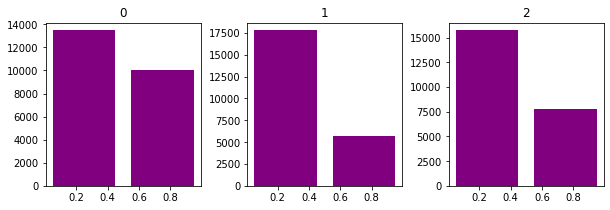

In [56]:
# Histogram of training data by label
Y_train_df.hist(bins=2, grid=False, layout=(1,3), 
                figsize=(10,3), rwidth=0.8, color='purple')

array([[<AxesSubplot:title={'center':'0'}>, <AxesSubplot:title={'center':'1'}>, <AxesSubplot:title={'center':'2'}>]], dtype=object)

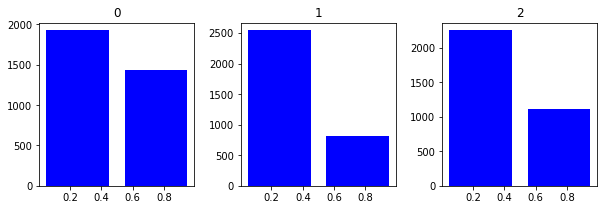

In [59]:
# Histogram of validation data by label
Y_valid_df.hist(bins=2, grid=False, layout=(1,3),
                figsize=(10,3), rwidth=0.8, color='blue')

In [25]:
print( "Data dimensions: ")
# same for years 10 and 1
print( "Y1 Training Set:", np.shape(X_train_1), "Labels:", np.shape(Y_train)) 
print( "Y1 Test Set:", np.shape(X_test_1), "Labels:", np.shape(Y_test))
print("Y1 Subset Test Set: ", np.shape(X_test_1_sub), "Labels:", np.shape(Y_test_sub))
print( "Y1 Validation Set:", np.shape(X_valid_1), "Labels:", np.shape(Y_valid), '\n')

print( "Y10 Training Set:", np.shape(X_train_10), "Labels:", np.shape(Y_train)) # same for year 10
print( "Y10 Test Set:", np.shape(X_test_10), "Labels:", np.shape(Y_test)) # same for year 10
print("Y10 Subset Test Set: ", np.shape(X_test_10_sub), "Labels:", np.shape(Y_test_sub)) 
print( "Y10 Validation Set:", np.shape(X_valid_10), "Labels:", np.shape(Y_valid)) # same for year 10

Data dimensions: 
Y1 Training Set: (23487, 3, 100, 100) Labels: (23487, 3)
Y1 Test Set: (6715, 3, 100, 100) Labels: (6715, 3)
Y1 Validation Set: (3355, 3, 100, 100) Labels: (3355, 3) 

Y10 Training Set: (23487, 3, 100, 100) Labels: (23487, 3)
Y10 Test Set: (6715, 3, 100, 100) Labels: (6715, 3)
Y10 Validation Set: (3355, 3, 100, 100) Labels: (3355, 3)


### Summary Of Dataset Attributes

Each image represents a series of pixels in a grid-like format with a value of brightness for each pixel.

```
Multi-Class Classification
3 classes: spiral (or '0'), elliptical ('1'), or a galaxy merger ('2’)

Training set details:
• 23487 total images
• 10017 Spiral galaxies (mean: 0.426491, std: 0.494577)
• 5705 Elliptical galaxies (mean: 0.242900, std: 0.428844)
• 7765 Merger galaxies (mean: 0.330608, std: 0.470442)
• Memory usage: 550.6 KB

Test set details:
• 6715 total images
• 2863 Spiral galaxies (mean: 0.426359, std: 0.494584)
• 1631 Elliptical galaxies (mean: 0.242889, std: 0.428861)
• 2221 Merger galaxies (mean: 0.330752, std: 0.470519)
• Memory usage: 157.5 KB

Validation set details:
• 3355 total images
• 1432 Spiral galaxies (mean: 0.426826, std: 0.494690)
• 815 Elliptical galaxies (mean: 0.242921, std: 0.428912)
• 1108 Merger galaxies (mean: 0.330253, std: 0.470374)
• Memory usage: 78.8 KB
```

# Training Status

#### Training with year 1 data (noisy):

**Model 1 (complete):**

*Accuracy: 79% (Y1 train), 66% (Y1 test), 67% (Y1 validation), 48% (Y10 test)

*Precision (weighted): 80% (Y1 train), 67% (Y1 test), 67% (Y1 validation)

*Recall (weighted): 79% (Y1 train), 66% (Y1 test), 67% (Y1 validation)

*F1 (weighted): 79% (Y1 train), 66% (Y1 test), 67% (Y1 validation)

*higher loss: validation

**Model 1.1 (complete):**

*Accuracy: 33% (Y1 train), 11% (Y1 test), 33% (Y1 validation), 16% (Y10 test)

*Precision (weighted): 33% (Y1 train), 11% (Y1 test), 33% (Y1 validation), 16% (Y10 test)

*Recall (weighted): 33% (Y1 train), 11% (Y1 test), 33% (Y1 validation), 16% (Y10 test)

*F1 (weighted): 33% (Y1 train), 11% (Y1 test), 33% (Y1 validation), 16% (Y10 test)

*higher loss: same

**Model 1.2 (complete):**

*Accuracy: 28% (Y1 train), 27% (Y1 test), 28% (Y1 validation), 27% (Y10 test)

*Precision (weighted): 43% (Y1 train), 40% (Y1 test), 42% (Y1 validation), 38% (Y10 test)

*Recall (weighted): 28% (Y1 train), 27% (Y1 test), 28% (Y1 validation), 27% (Y10 test)

*F1 (weighted): 24% (Y1 train), 23% (Y1 test), 23% (Y1 validation), 19% (Y10 test)

*higher loss: validation

**Model 1.3 (complete):**

*Accuracy: 31% (Y1 train), 31% (Y1 test), 31% (Y1 validation), 50% (Y10 test)

*Precision (weighted): 42% (Y1 train), 43% (Y1 test), 42% (Y1 validation), 50% (Y10 test)

*Recall (weighted): 31% (Y1 train), 31% (Y1 test), 31% (Y1 validation), 50% (Y10 test)

*F1 (weighted): 27% (Y1 train), 28% (Y1 test), 27% (Y1 validation), 49% (Y10 test)

*higher loss: Validation

**Model 1.4 (complete):**

*Accuracy: 65% (Y1 train), 56% (Y1 test), 55% (Y1 validation), 41% (Y10 test)

*Precision (weighted): 73% (Y1 train), 65% (Y1 test), 63% (Y1 validation), 43% (Y10 test)

*Recall (weighted): 65% (Y1 train), 56% (Y1 test), 55% (Y1 validation), 41% (Y10 test)

*F1 (weighted): 65% (Y1 train), 56% (Y1 test), 54% (Y1 validation), 40% (Y10 test)

*higher loss: Validation

**Model 1.5 (complete):**

*Accuracy: 43% (Y1 train), 43% (Y1 test), 43% (Y1 validation), 43% (Y10 test)

*Precision (weighted): 18% (Y1 train), 18% (Y1 test), 18% (Y1 validation), 18% (Y10 test)

*Recall (weighted): 43% (Y1 train), 43% (Y1 test), 43% (Y1 validation), 43% (Y10 test)

*F1 (weighted): 26% (Y1 train), 25% (Y1 test), 26% (Y1 validation), 25% (Y10 test)

*higher loss: same

**Model 2 (complete):**

*Accuracy: 68% (Y1 train), 63% (Y1 test), 63% (Y1 validation), 60% (Y10 test)

*Precision (weighted): 68% (Y1 train), 63% (Y1 test), 63% (Y1 validation), 61% (Y10 test)

*Recall (weighted): 68% (Y1 train), 63% (Y1 test), 63% (Y1 validation), 60% (Y10 test)

*F1 (weighted): 68% (Y1 train), 63% (Y1 test), 63% (Y1 validation), 58% (Y10 test)

*higher loss: Validation

**Model 3 (complete):**

*Accuracy: 70% (Y1 train), 62% (Y1 test), 63% (Y1 validation), 45% (Y10 test)

*Precision (weighted): 72% (Y1 train), 63% (Y1 test), 64% (Y1 validation), 59% (Y10 test)

*Recall (weighted): 70% (Y1 train), 62% (Y1 test), 63% (Y1 validation), 45% (Y10 test)

*F1 (weighted): 69% (Y1 train), 61% (Y1 test), 62% (Y1 validation), 30% (Y10 test)

*higher loss: Validation

**Training  with year 10 data (pristine):**


# Overview

First build a standard deterministic CNN classifier model as a baseline model. CNN/ConvNet typically uses convolutional layers, pooling layers, and fully-connected layers. The layer setup is such that simpler patterns are recognized first, then increasingly complex patterns thereafter. Perform series of convolution + pooling operations, then a number of fully connected layers. 

**Convolutional Layer:** Contains most of the network's main computational load. Performs dot product between kernel (matrix 1) and restricted portion of the receptive field (matrix 2). Forward pass. Creates an activation/feature map, or 2D representation of the image.

**Pooling Layer:** provides summary statistic of nearby outputs at various network output locations. Pooling operation performed individually on every slice of activation map. Max pooling is most popular.

**Fully Connected Layer:** helps map the representation b/w input and the output. Matrix multiplication, followed by a bias effect. Helps to learn non-linear combinations of features.

**Activation function:**

ReLU/'relu': Rectified Linear Unit, calculates ƒ(κ)=max (0,κ), or the activation is simply threshold at 0. More reliable + faster than sigmoid, tanh. More non-linearity gives more power to the model. Used for all but last layer.

-Softmax/Normalized Exponential: converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector. Because labels are one-hot encoded, this will be used for final fully connected layer for 3 classes.

**Regularizations:**

Dropout: Most popular regularization technique, prevents overfitting. At each iteration, neuron temporarily “dropped” with probability 'p'. This neuron is resampled with 'p' at every training step, so will be active at next step. Typically ~0.5 or 50%. Can be applied to input or hidden layer nodes, but not output nodes. Attempted to use rates of 0.5 and 0.8, as not enough computing power to use GridSearchCV to determine best rate.

Batch Normalization: Explicitly forces the activations throughout a network to take on a Gaussian distribution at the beginning of training, applying a transformation that maintains mean output close to 0 and output standard deviation close to 1. BatchNorm layer inserted immediately after fully connected layers, or convolutional layers, and before non-linearities. Significantly more robust to bad initialization.

L2: kernel regularization.

**Callbacks:**

Early stopping: callback function can be used to monitor either accuracy or loss, stopping when there's either a loss increment, or accuracy decrement. Should monitor the thing that is more sensitive, which is usually loss function- will start seeing signs of overfitting in loss earlier. 

Model Checkpoint: Save only best weights in order to maximize, in this case, validation accuracy (only saves when the model is considered the "best").

ReduceLROnPlateau: Attempt to adjust learning rate, in this case by 0.1, if validation loss begins to plateau. Did not implement until Model 2.

BackupAndRestore: Save backup of model in case training is interrupted.

**Optimizers:**

Adam: implements the Adam algorithm; learning rate of 0.001. Stochastic gradient descent method based on adaptive estimation of 1st-order and 2nd-order moments, very performant and recommended by similar papers for this type of project.

**Loss function:** 

Categorical Cross-entropy: Computes the cross-entropy loss between the labels and predictions. Used when adjusting model weights during training. Categorical cross-entropy is used with 'softmax' activation for multi-class classification problem, i.e. when true label values are one-hot encoded for 3-class classification problem, as is the case with this project.

# Define Training Variables & Functions

In [5]:
# 3 Classes
class_names = ['Spiral', 'Elliptical', 'Merger']
NUM_CLASSES = len(class_names)

In [6]:
# Imbalanced dataset: use class weights
def generate_class_weights(class_series):
    # class is one-hot encoded, so transform to categorical labels to use compute_class_weight   
    class_series = np.argmax(class_series, axis=1)
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    
    return dict(zip(class_labels, class_weights))

class_weights = generate_class_weights(Y_train)
print('Training class weights:', generate_class_weights(Y_train))
print('Test class weights:', generate_class_weights(Y_test))
print('Validation class weights:', generate_class_weights(Y_valid))

Training class weights: {0: 0.7815713287411401, 1: 1.372304995617879, 2: 1.0082421120412106}
Test class weights: {0: 0.7818139480731168, 1: 1.3723686899652565, 2: 1.0078042923607984}
Validation class weights: {0: 0.7809590316573557, 1: 1.3721881390593047, 2: 1.0093261131167268}


In [7]:
# check data sizes
NUM_TRAIN = 23487
NUM_TEST = 6715
NUM_VALIDATION = 3355
NUM_TOTAL = NUM_TRAIN + NUM_TEST + NUM_VALIDATION
print(NUM_TOTAL)
assert NUM_TOTAL == len(X_train_1) + len(X_test_1) + len(X_valid_1), "total\
training, test, validation samples not equal to total samples - exiting"

33557


In [7]:
# Compile model
def compile_model(model, loss, optimizer):
    metrics = ['accuracy']
    model.compile(optimizer = optimizer,loss = loss, metrics = metrics)
    model.summary()

In [8]:
# Visualize training history
def plot_training(model, history):
    
    # Function to plot the Accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Function to plot the Loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = list(range(len(loss)))
    
    ### Plotting
    # plot accuracy
    figsize=(6, 4)
    figure = plt.figure(figsize=figsize)
    plt.plot(epochs, acc, 'navy', label='Accuracy')
    plt.plot(epochs, val_acc, 'deepskyblue', label= "Validation Accuracy")    
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f"{model.name} Accuracy Training History")
    plt.legend(loc='best')
    #plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(fname=f"{model.name} Accuracy Training History", format='png')
    plt.show()

    # plot loss
    figsize=(6, 4)
    figure = plt.figure(figsize=figsize)
    plt.plot(epochs, loss, 'red', label='Loss')
    plt.plot(epochs, val_loss, 'lightsalmon', label= "Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"{model.name} Loss Training History")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(fname=f"{model.name} Loss Training History", format='png')
    plt.show()

In [9]:
# Evaluate model on datasets
def evaluate_model(model, x_data, y_data):
    score = model.evaluate(x_data, y_data, verbose=True)
    print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

In [10]:
def make_classification_report(y_data, y_pred):
    classification_metrics = classification_report(y_data, y_pred, target_names=class_names)
    return classification_metrics
    

In [11]:
def make_cm(model, y_data, y_pred):
    labels = [0, 1, 2]
    cm = confusion_matrix(y_data, y_pred, labels=labels)
    cm = cm.astype('float')
    cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
    return cd

In [12]:
# Save model data
def save_model_data(model, history):
    model.save(filepath = f'{model.name}.json', include_optimizer = True, overwrite = True)
    
    # Saving history as .npy file for future use
    np.save(f'{model.name}_history.npy', history.history)

In [74]:
#tf.keras.backend.clear_session()

# Deterministic CNN Model

### Model 1

Similar to DeepMerge architecture

Loss: Categorical Cross-entropy

Optimizer: Adam (default learning rate)

Uses Image Augmentation: False

In [45]:
## Define model architecture with the Functional API
# channels first: (channels, rows, cols)
input_shape = (3, 100, 100)

# Input layer (visible layer)
x = Input(shape=input_shape)

# Hidden layers
c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.1)(d0)

c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.1)(d1)

c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.1)(d2)

# Flatten the 3D output to 1D
f = Flatten()(e2)
z0 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
# Output layer: creates 3 one-hot encoded output values, one for each class
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z1)

model = Model(inputs=x, outputs=y, name="Model-1")

## Compile Model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
compile_model(model, loss=loss, optimizer = optimizer)

Model: "Model-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization_15 (Bat  (None, 8, 100, 100)      400       
 chNormalization)                                                
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout_15 (Dropout)        (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                           

In [46]:
## Define Callback Functions
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
      ModelCheckpoint(filepath='Y1_best_weights.h5', monitor='val_accuracy',
                      mode='max', verbose=0, save_best_only=True)
      ]

In [47]:
## Train Model
batch_size = 128
NUM_EPOCH = 200
history = model.fit(X_train_1, Y_train,
                    batch_size = batch_size,
                    epochs = NUM_EPOCH,
                    validation_data = (X_valid_1, Y_valid),                
                    shuffle = True,
                    class_weight = class_weights,
                    verbose = 1,
                    callbacks = es
            )

Epoch 1/200


2022-09-18 13:06:12.831133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 1.1385 - accuracy: 0.4039

2022-09-18 13:07:21.475923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - 70s 377ms/step - loss: 1.1385 - accuracy: 0.4039 - val_loss: 1.2065 - val_accuracy: 0.3303
Epoch 2/200
184/184 [==============================] - 65s 355ms/step - loss: 1.0553 - accuracy: 0.4898 - val_loss: 1.0684 - val_accuracy: 0.4775
Epoch 3/200
184/184 [==============================] - 65s 351ms/step - loss: 1.0401 - accuracy: 0.5036 - val_loss: 1.2432 - val_accuracy: 0.2703
Epoch 4/200
184/184 [==============================] - 65s 351ms/step - loss: 1.0272 - accuracy: 0.5181 - val_loss: 1.2657 - val_accuracy: 0.2903
Epoch 5/200
184/184 [==============================] - 65s 351ms/step - loss: 1.0063 - accuracy: 0.5299 - val_loss: 1.3337 - val_accuracy: 0.5285
Epoch 6/200
184/184 [==============================] - 65s 351ms/step - loss: 0.9857 - accuracy: 0.5406 - val_loss: 1.0472 - val_accuracy: 0.4972
Epoch 7/200
184/184 [==============================] - 64s 349ms/step - loss: 0.9623 - accuracy: 0.5548 - val_loss: 1.4472 - val_accurac

In [48]:
# Evaluate model on test sets
evaluate_model(model, X_test_1, Y_test)
evaluate_model(model, X_test_10, Y_test)
evaluate_model(model, X_test_1_sub, Y_test_sub)
evaluate_model(model, X_test_10_sub, Y_test_sub)

# Save model data
save_model_data(model, history)

210/210 [==============================] - 3s 13ms/step - loss: 0.8678 - accuracy: 0.6608
accuracy: 66.08%
210/210 [==============================] - 3s 13ms/step - loss: 2.1334 - accuracy: 0.4798
accuracy: 47.98%
5/5 [==============================] - 0s 23ms/step - loss: 0.7863 - accuracy: 0.6933
accuracy: 69.33%
5/5 [==============================] - 0s 13ms/step - loss: 2.0442 - accuracy: 0.4533
accuracy: 45.33%


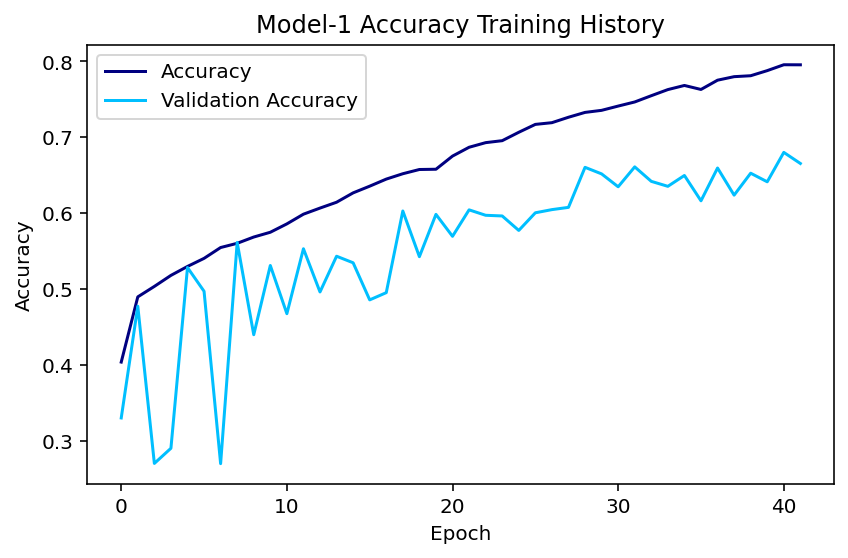

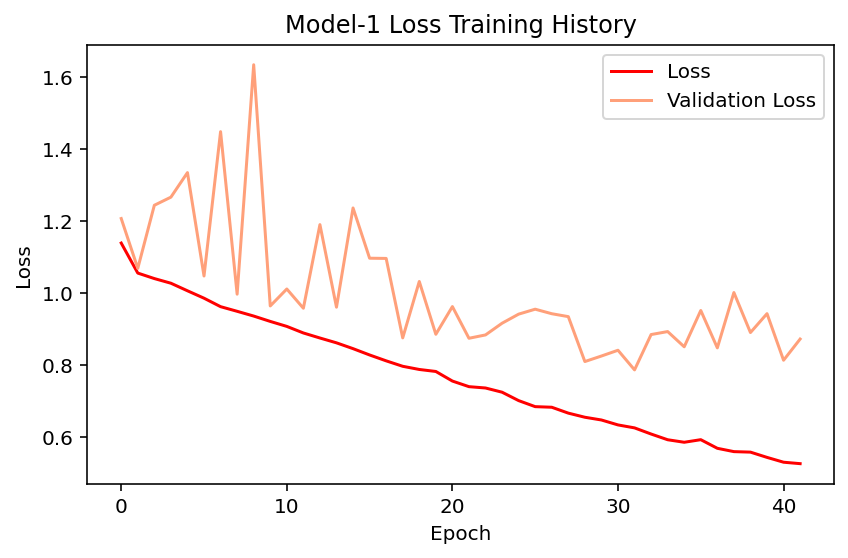

In [49]:
## Visualize training results
# Plot training history
plot_training(model, history)

734/734 [==============================] - 8s 11ms/step
Train:
              precision    recall  f1-score   support

      Spiral       0.81      0.87      0.84     10017
  Elliptical       0.70      0.84      0.76      5705
      Merger       0.85      0.65      0.73      7765

    accuracy                           0.79     23487
   macro avg       0.79      0.78      0.78     23487
weighted avg       0.80      0.79      0.79     23487


734/734 [==============================] - 8s 11ms/step


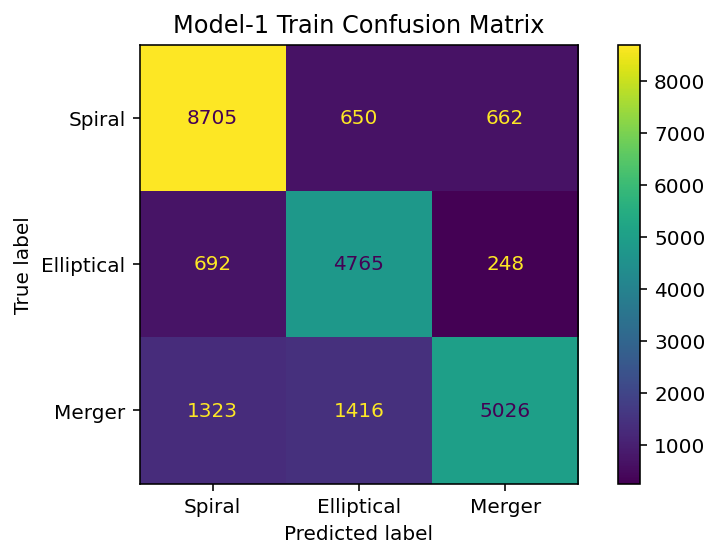

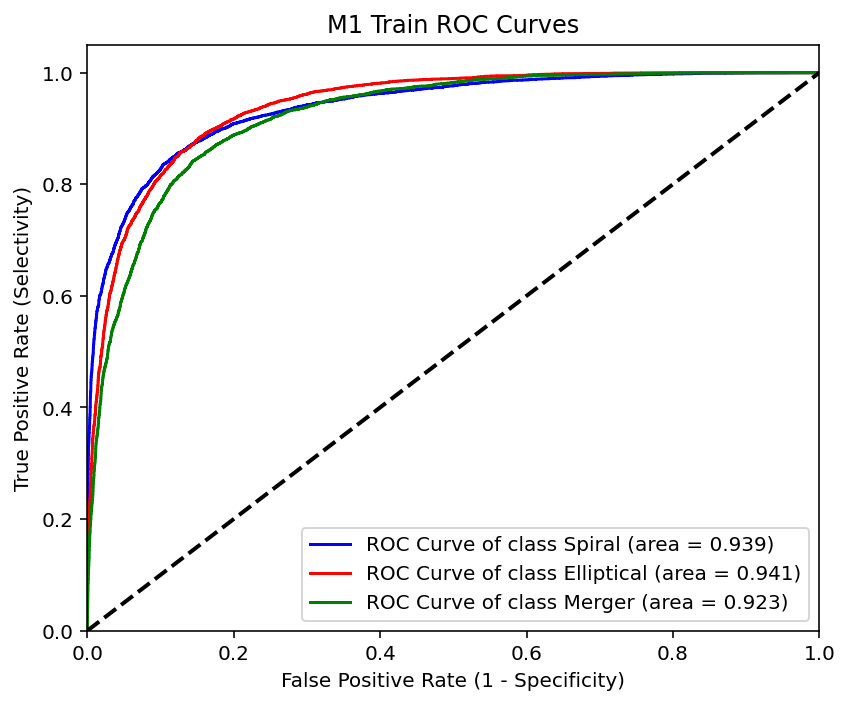

In [53]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model.predict(X_train_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_train, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model, 
              np.argmax(Y_train, axis=1), 
              np.argmax(model.predict(X_train_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model.name} Train Confusion Matrix')
plt.tight_layout()
plt.savefig(fname='M1_train_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('M1 Train ROC Curves')
plt.savefig(fname='M1_train_ROC', format='png')
plt.show()

210/210 [==============================] - 2s 11ms/step
Test:
              precision    recall  f1-score   support

      Spiral       0.72      0.79      0.75      2863
  Elliptical       0.55      0.67      0.61      1631
      Merger       0.68      0.48      0.56      2221

    accuracy                           0.66      6715
   macro avg       0.65      0.65      0.64      6715
weighted avg       0.67      0.66      0.66      6715


210/210 [==============================] - 2s 10ms/step


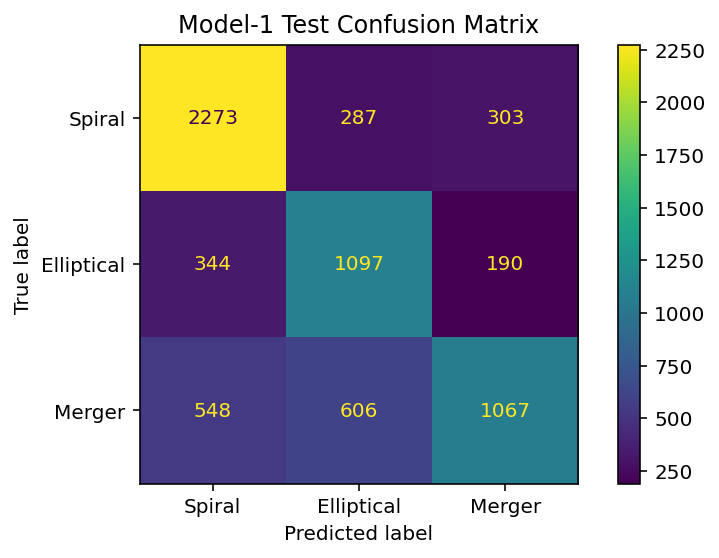

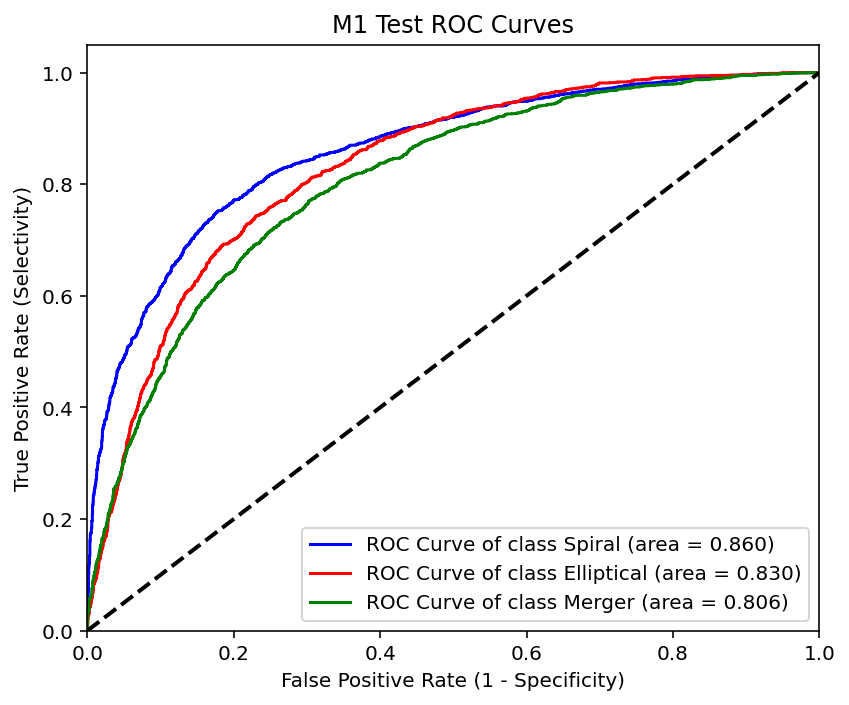

In [54]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model.predict(X_test_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model, 
              np.argmax(Y_test, axis=1), 
              np.argmax(model.predict(X_test_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model.name} Test Confusion Matrix')
plt.tight_layout()
plt.savefig(fname='M1_test_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('M1 Test ROC Curves')
plt.savefig(fname='M1_test_ROC', format='png')
plt.show()

105/105 [==============================] - 1s 11ms/step
Validation:
              precision    recall  f1-score   support

      Spiral       0.73      0.78      0.75      1432
  Elliptical       0.55      0.67      0.61       815
      Merger       0.68      0.51      0.59      1108

    accuracy                           0.67      3355
   macro avg       0.65      0.65      0.65      3355
weighted avg       0.67      0.67      0.66      3355


105/105 [==============================] - 1s 10ms/step


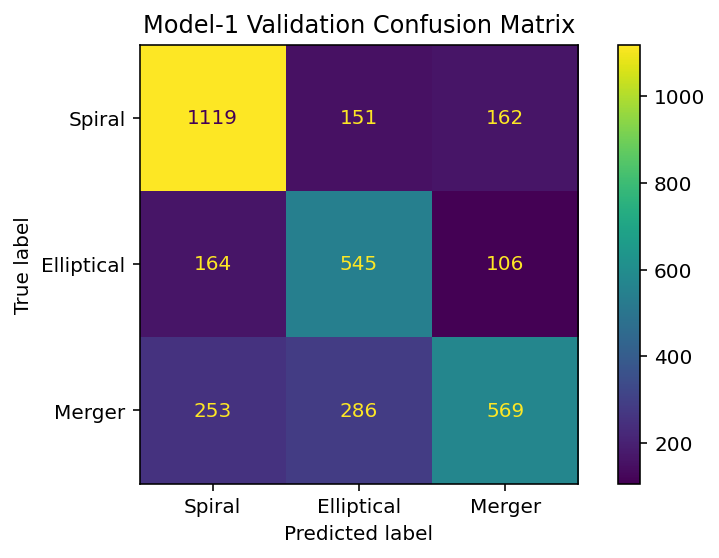

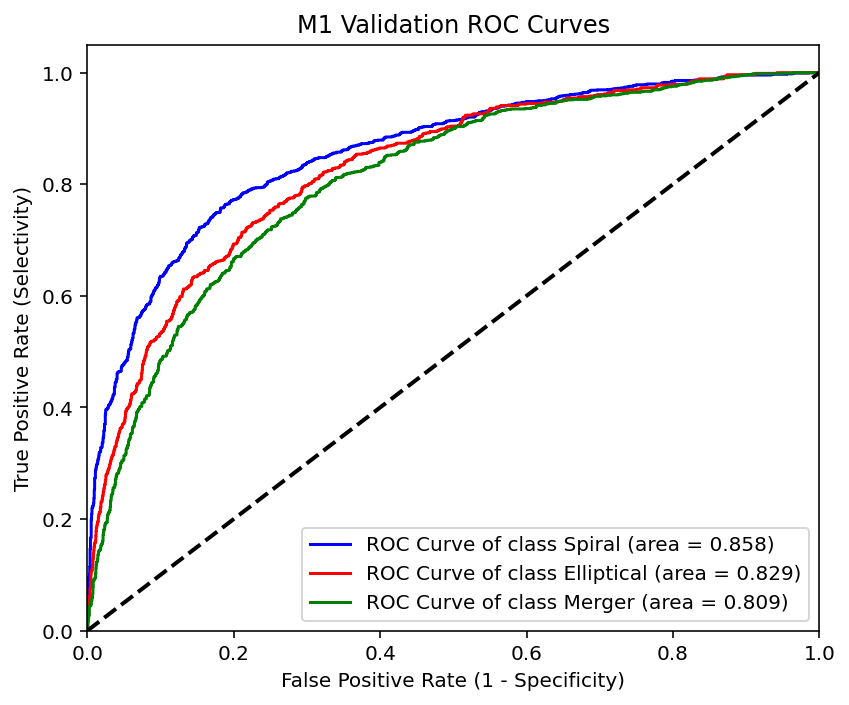

In [56]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model.predict(X_valid_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_valid, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Validation:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model, 
              np.argmax(Y_valid, axis=1), 
              np.argmax(model.predict(X_valid_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model.name} Validation Confusion Matrix')
plt.tight_layout()
plt.savefig(fname='M1_validation_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('M1 Validation ROC Curves')
plt.tight_layout()
plt.savefig(fname='M1_validation_ROC', format='png')
plt.show()

### Model 1.1

Similar to DeepMerge architecture

Loss: Categorical Cross-entropy

Optimizer: Adam (default learning rate)

Uses Image Augmentation: True (rotation_range=180, width_shift_range=0.8, height_shift_range=0.8, shear_range=0.8, zoom_range=0.8, vertical_flip = True, horizontal_flip=True)

In [14]:
## Define model architecture with the Functional API
input_shape = (3, 100, 100)
x = Input(shape=input_shape)

c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.1)(d0)

c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.1)(d1)

c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.1)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z1)

model_1_1 = Model(inputs=x, outputs=y, name="Model-1.1")

## Compile Model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
compile_model(model=model_1_1, loss=loss, optimizer = optimizer)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-09-18 18:28:17.938201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-18 18:28:17.939440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "Model-1.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization (BatchN  (None, 8, 100, 100)      400       
 ormalization)                                                   
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout (Dropout)           (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                         

In [15]:
## Define Callback Functions
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
      ModelCheckpoint(filepath='Y1_best_weights.h5', monitor='val_accuracy',
                      mode='max', verbose=0, save_best_only=True)
      ]

In [16]:
## Define Image Augmentation
datagen = ImageDataGenerator(
      rotation_range=360,
      width_shift_range=0.9,               
      height_shift_range=0.9,
      shear_range=0.9,
      zoom_range=0.9,
      vertical_flip = True,
      horizontal_flip=True
)
datagen.fit(X_train_1)

In [18]:
## Train Model
batch_size = 128
NUM_EPOCH = 200
history_1_1 = model_1_1.fit(datagen.flow(X_train_1, Y_train),
                                batch_size = batch_size,
                                epochs = NUM_EPOCH,
                                validation_data = datagen.flow(X_valid_1, Y_valid),                
                                shuffle = True,
                                class_weight = class_weights,
                                verbose = 1,
                                callbacks = es
                        )

Epoch 1/200


2022-09-18 18:29:16.591099: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-18 18:29:17.455239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - ETA: 0s - loss: 1.1142 - accuracy: 0.4000

2022-09-18 18:30:29.702736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 80s 105ms/step - loss: 1.1142 - accuracy: 0.4000 - val_loss: 1.0897 - val_accuracy: 0.4325
Epoch 2/200
734/734 [==============================] - 76s 104ms/step - loss: 1.0838 - accuracy: 0.4369 - val_loss: 1.0829 - val_accuracy: 0.4268
Epoch 3/200
734/734 [==============================] - 76s 104ms/step - loss: 1.0768 - accuracy: 0.4590 - val_loss: 1.0768 - val_accuracy: 0.4408
Epoch 4/200
734/734 [==============================] - 76s 104ms/step - loss: 1.0732 - accuracy: 0.4608 - val_loss: 1.0808 - val_accuracy: 0.4513
Epoch 5/200
734/734 [==============================] - 77s 105ms/step - loss: 1.0667 - accuracy: 0.4629 - val_loss: 1.2303 - val_accuracy: 0.2537
Epoch 6/200
734/734 [==============================] - 76s 104ms/step - loss: 1.0626 - accuracy: 0.4637 - val_loss: 2.2590 - val_accuracy: 0.2429
Epoch 7/200
734/734 [==============================] - 76s 104ms/step - loss: 1.0618 - accuracy: 0.4738 - val_loss: 1.0846 - val_accurac

In [19]:
# Evaluate model on test sets
evaluate_model(model_1_1, X_test_1, Y_test)
evaluate_model(model_1_1, X_test_10, Y_test)
evaluate_model(model_1_1, X_test_1_sub, Y_test_sub)
evaluate_model(model_1_1, X_test_10_sub, Y_test_sub)

## Save model data
save_model_data(model_1_1, history_1_1)

210/210 [==============================] - 3s 12ms/step - loss: 1.0975 - accuracy: 0.3308
accuracy: 33.08%
210/210 [==============================] - 3s 13ms/step - loss: 1.0975 - accuracy: 0.3308
accuracy: 33.08%
5/5 [==============================] - 0s 25ms/step - loss: 1.0990 - accuracy: 0.3333
accuracy: 33.33%
5/5 [==============================] - 0s 13ms/step - loss: 1.0990 - accuracy: 0.3333
accuracy: 33.33%


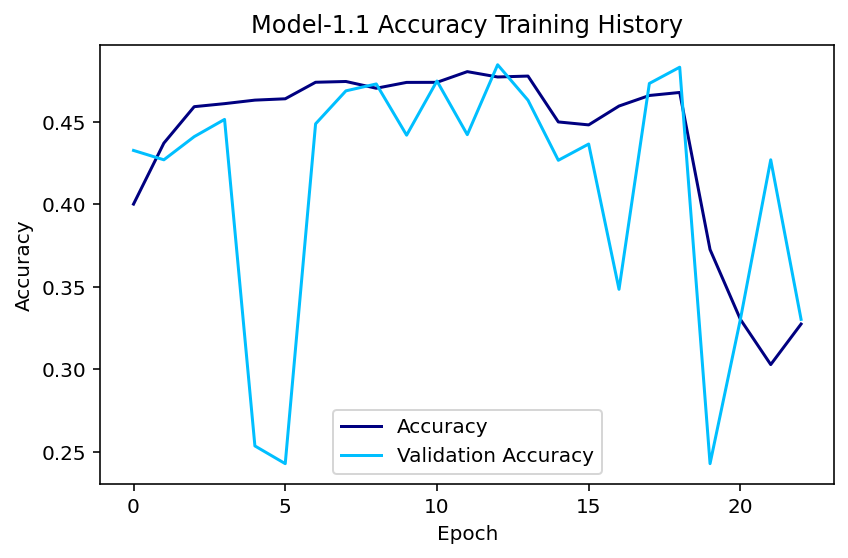

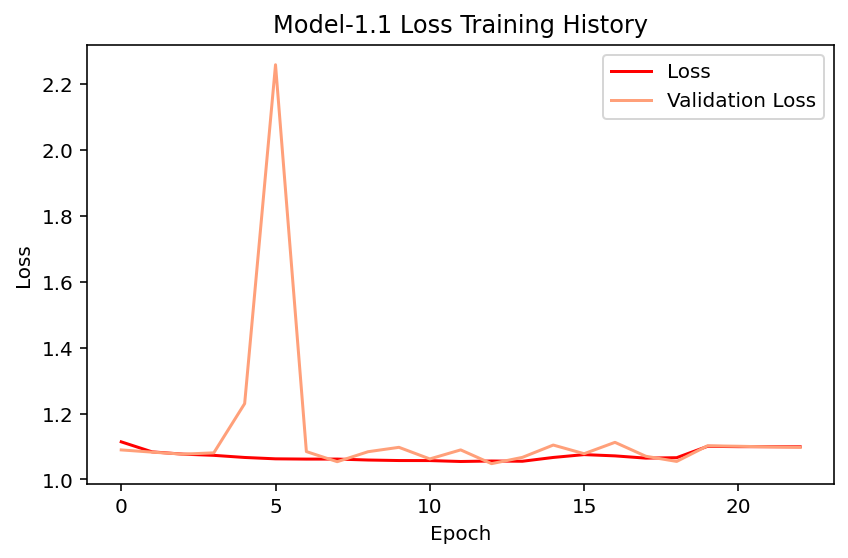

In [22]:
## Visualize training results
# Plot training history
plot_training(model_1_1, history_1_1)

  2/734 [..............................] - ETA: 44s 

2022-09-18 19:02:55.198692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 7s 9ms/step
Train:
              precision    recall  f1-score   support

      Spiral       0.00      0.00      0.00     10017
  Elliptical       0.00      0.00      0.00      5705
      Merger       0.33      1.00      0.50      7765

    accuracy                           0.33     23487
   macro avg       0.11      0.33      0.17     23487
weighted avg       0.11      0.33      0.16     23487


734/734 [==============================] - 6s 9ms/step


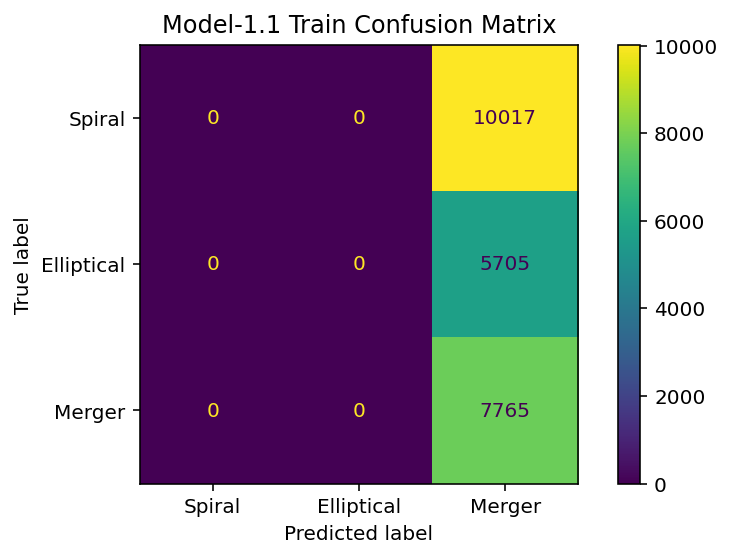

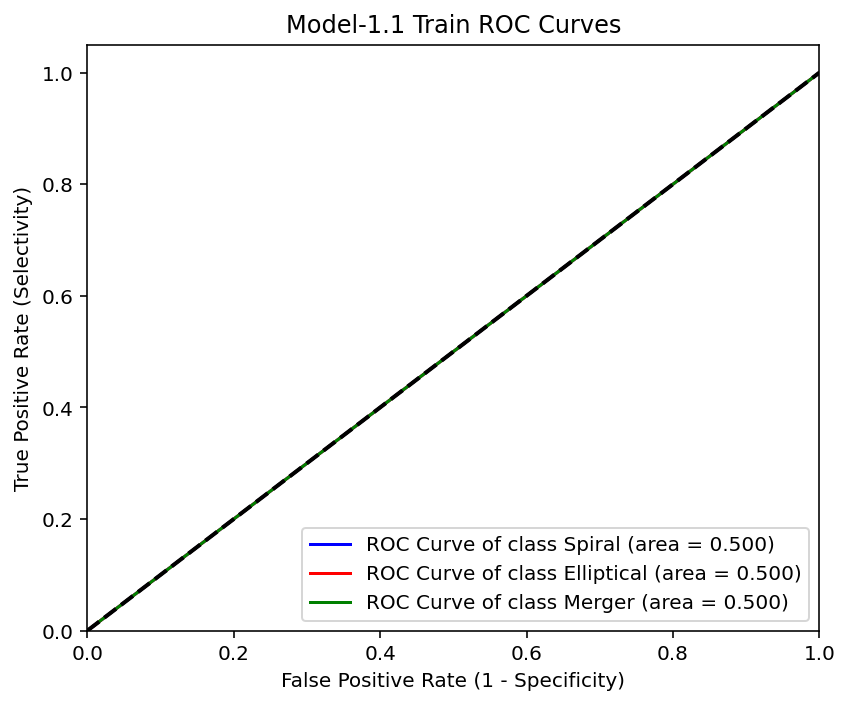

In [23]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_1.predict(X_train_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_train, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_1_1, 
              np.argmax(Y_train, axis=1), 
              np.argmax(model_1_1.predict(X_train_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_1_1.name} Train Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_1_1.name}_train_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_1_1.name} Train ROC Curves')
plt.savefig(fname=f'{model_1_1.name}_train_ROC', format='png')
plt.show()

210/210 [==============================] - 2s 9ms/step
Test:
              precision    recall  f1-score   support

      Spiral       0.00      0.00      0.00      2863
  Elliptical       0.00      0.00      0.00      1631
      Merger       0.33      1.00      0.50      2221

    accuracy                           0.33      6715
   macro avg       0.11      0.33      0.17      6715
weighted avg       0.11      0.33      0.16      6715


210/210 [==============================] - 2s 9ms/step


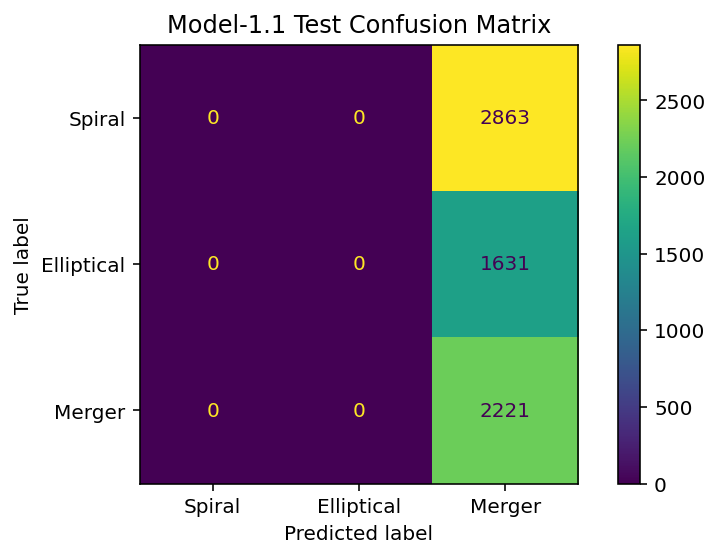

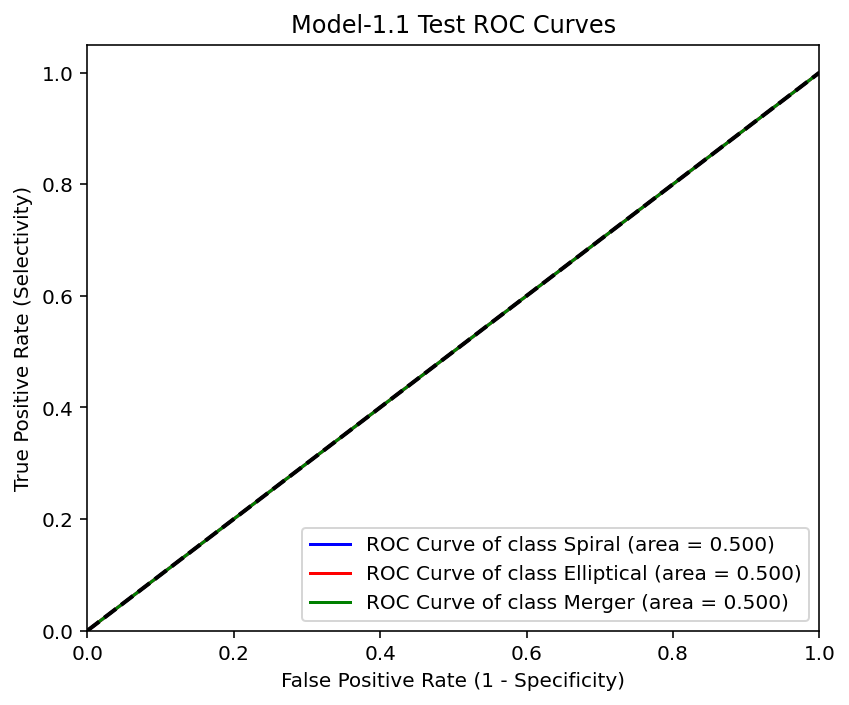

In [24]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_1.predict(X_test_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_1_1, 
              np.argmax(Y_test, axis=1), 
              np.argmax(model_1_1.predict(X_test_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_1_1.name} Test Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_1_1.name}_test_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_1_1.name} Test ROC Curves')
plt.savefig(fname=f'{model_1_1.name}_test_ROC', format='png')
plt.show()

105/105 [==============================] - 1s 9ms/step
Test:
              precision    recall  f1-score   support

      Spiral       0.00      0.00      0.00      1432
  Elliptical       0.00      0.00      0.00       815
      Merger       0.33      1.00      0.50      1108

    accuracy                           0.33      3355
   macro avg       0.11      0.33      0.17      3355
weighted avg       0.11      0.33      0.16      3355


105/105 [==============================] - 1s 9ms/step


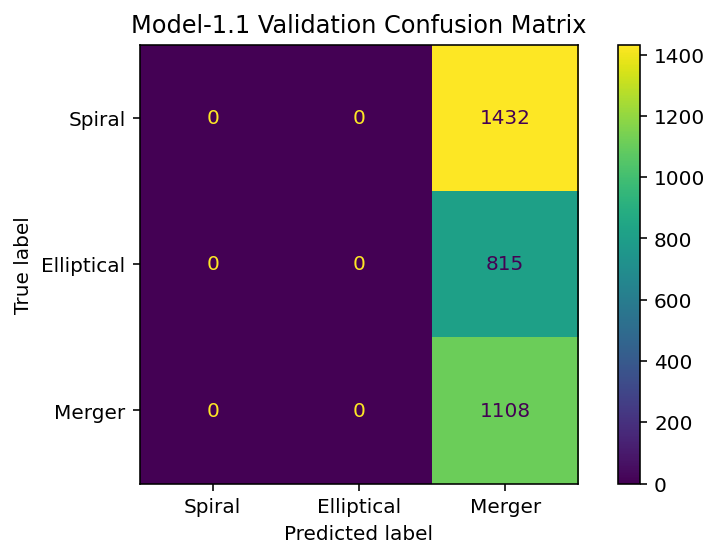

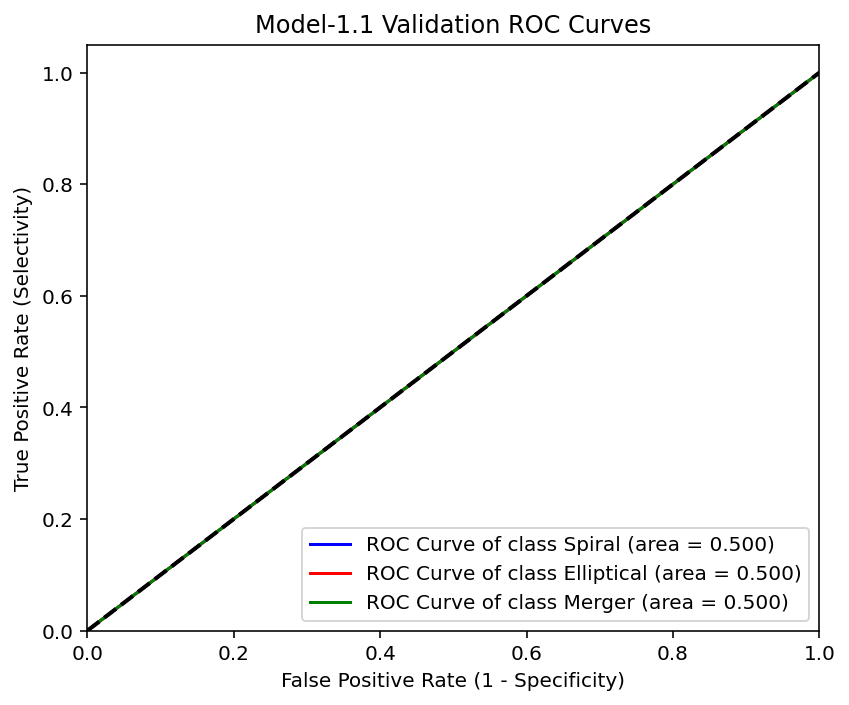

In [25]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_1.predict(X_valid_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_valid, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_1_1, 
              np.argmax(Y_valid, axis=1), 
              np.argmax(model_1_1.predict(X_valid_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_1_1.name} Validation Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_1_1.name}_validation_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_1_1.name} Validation ROC Curves')
plt.savefig(fname=f'{model_1_1.name}_validation_ROC', format='png')
plt.show()

In [26]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_1.predict(X_test_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Year 10 Test:\n" + classification_metrics + '\n')

210/210 [==============================] - 2s 9ms/step
Year 10 Test:
              precision    recall  f1-score   support

      Spiral       0.00      0.00      0.00      2863
  Elliptical       0.00      0.00      0.00      1631
      Merger       0.33      1.00      0.50      2221

    accuracy                           0.33      6715
   macro avg       0.11      0.33      0.17      6715
weighted avg       0.11      0.33      0.16      6715




### Model 1.2

Similar to DeepMerge architecture

Loss: Categorical Cross-entropy

Optimizer: Adam (default learning rate)

Uses Image Augmentation: False

Change: Dropout 0.1 -> 0.5

In [27]:
## Define model architecture
x = Input(shape=input_shape)
c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.5)(d0)

c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.5)(d1)

c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z1)

model_1_2 = Model(inputs=x, outputs=y, name='Model-1.2')

## Compile Model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
compile_model(model_1_2, loss=loss, optimizer=optimizer)

Model: "Model-1.2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization_3 (Batc  (None, 8, 100, 100)      400       
 hNormalization)                                                 
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout_3 (Dropout)         (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                         

In [28]:
## Define Callback Functions
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
      ModelCheckpoint(filepath='Y1_best_weights.h5', monitor='val_accuracy',
                      mode='max', verbose=1, save_best_only=True)
     ] 

In [29]:
## Train Model
batch_size = 128
NUM_EPOCH = 200
history_1_2 = model_1_2.fit(X_train_1, Y_train,
                    batch_size = batch_size,
                    epochs = NUM_EPOCH,
                    validation_data = (X_valid_1, Y_valid),
                    shuffle = True,
                    class_weight = class_weights,
                    verbose = 1,
                    callbacks = es
            )

Epoch 1/200


2022-09-18 19:06:34.299915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 1.1410 - accuracy: 0.3937

2022-09-18 19:07:42.487458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.33025, saving model to Y1_best_weights.h5
184/184 [==============================] - 70s 373ms/step - loss: 1.1410 - accuracy: 0.3937 - val_loss: 18.7996 - val_accuracy: 0.3303
Epoch 2/200
184/184 [==============================] - ETA: 0s - loss: 1.0630 - accuracy: 0.4861
Epoch 2: val_accuracy did not improve from 0.33025
184/184 [==============================] - 66s 360ms/step - loss: 1.0630 - accuracy: 0.4861 - val_loss: 18.1892 - val_accuracy: 0.3303
Epoch 3/200
184/184 [==============================] - ETA: 0s - loss: 1.0745 - accuracy: 0.4575
Epoch 3: val_accuracy did not improve from 0.33025
184/184 [==============================] - 66s 359ms/step - loss: 1.0745 - accuracy: 0.4575 - val_loss: 18.1326 - val_accuracy: 0.2429
Epoch 4/200
184/184 [==============================] - ETA: 0s - loss: 1.0539 - accuracy: 0.4970
Epoch 4: val_accuracy did not improve from 0.33025
184/184 [==============================] - 66s 361ms/step - lo

In [30]:
# Evaluate model on test sets
evaluate_model(model_1_2, X_test_1, Y_test)
evaluate_model(model_1_2, X_test_10, Y_test)
evaluate_model(model_1_2, X_test_1_sub, Y_test_sub)
evaluate_model(model_1_2, X_test_10_sub, Y_test_sub)

## Save model data
save_model_data(model_1_2, history_1_2)

210/210 [==============================] - 3s 13ms/step - loss: 2.2975 - accuracy: 0.2703
accuracy: 27.03%
210/210 [==============================] - 3s 14ms/step - loss: 2.5041 - accuracy: 0.2742
accuracy: 27.42%
5/5 [==============================] - 0s 25ms/step - loss: 2.4396 - accuracy: 0.2933
accuracy: 29.33%
5/5 [==============================] - 0s 14ms/step - loss: 2.4684 - accuracy: 0.3400
accuracy: 34.00%


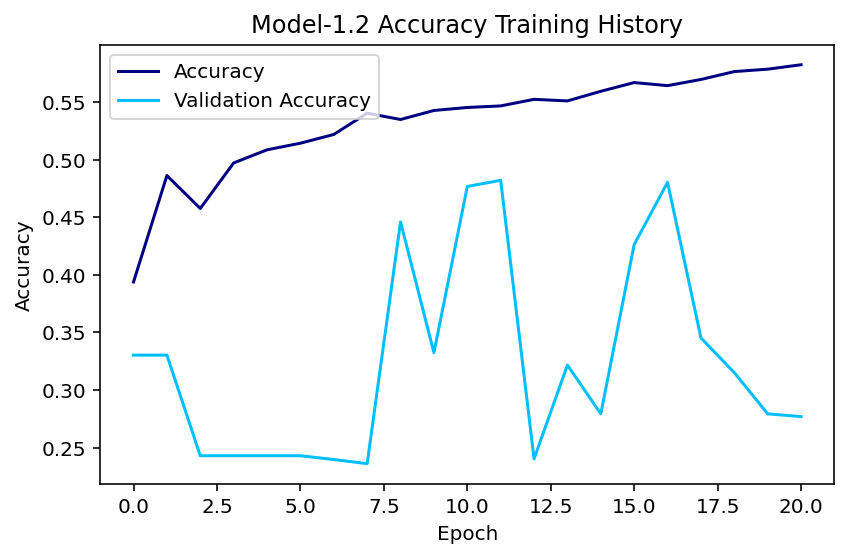

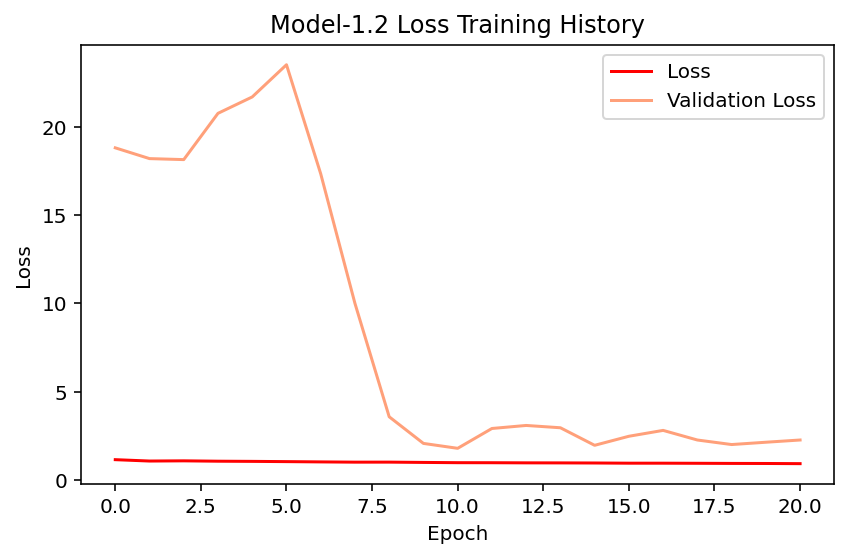

In [39]:
## Visualize training results
# Plot training history
plot_training(model_1_2, history_1_2)

  4/734 [..............................] - ETA: 13s 

2022-09-18 19:30:43.963334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 8s 11ms/step
Train:
              precision    recall  f1-score   support

      Spiral       0.58      0.19      0.29     10017
  Elliptical       0.22      0.75      0.34      5705
      Merger       0.37      0.05      0.09      7765

    accuracy                           0.28     23487
   macro avg       0.39      0.33      0.24     23487
weighted avg       0.43      0.28      0.24     23487


734/734 [==============================] - 8s 11ms/step


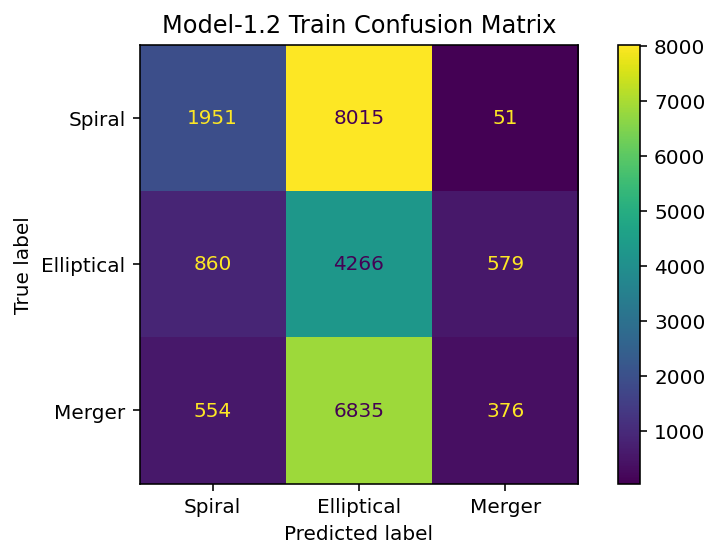

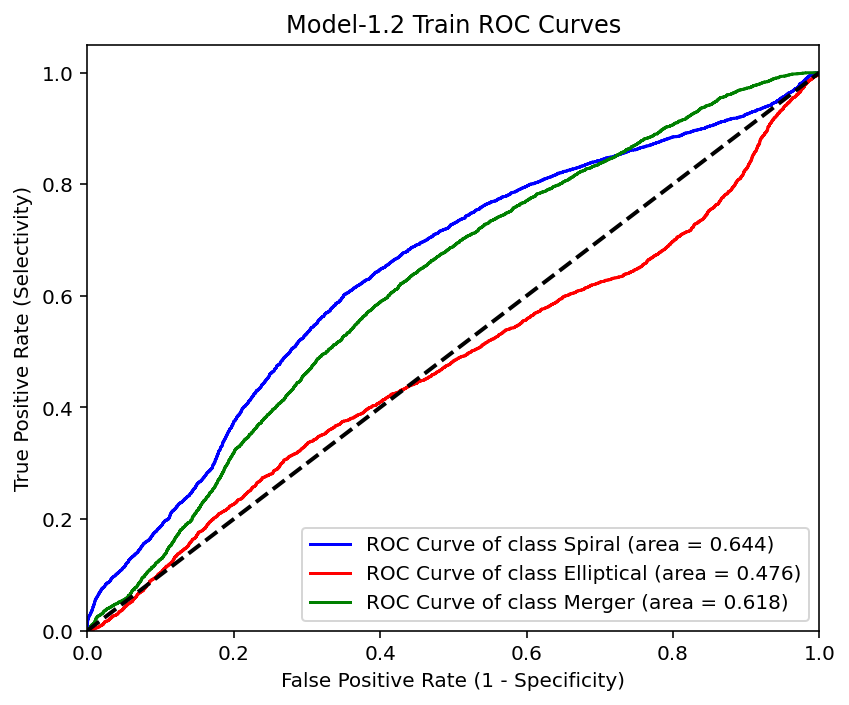

In [32]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_2.predict(X_train_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_train, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_1_2, 
              np.argmax(Y_train, axis=1), 
              np.argmax(model_1_2.predict(X_train_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_1_2.name} Train Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_1_2.name}_train_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_1_2.name} Train ROC Curves')
plt.savefig(fname=f'{model_1_2.name}_train_ROC', format='png')
plt.show()

210/210 [==============================] - 2s 11ms/step
Test:
              precision    recall  f1-score   support

      Spiral       0.54      0.19      0.28      2863
  Elliptical       0.22      0.71      0.33      1631
      Merger       0.34      0.05      0.09      2221

    accuracy                           0.27      6715
   macro avg       0.37      0.32      0.23      6715
weighted avg       0.40      0.27      0.23      6715


210/210 [==============================] - 2s 9ms/step


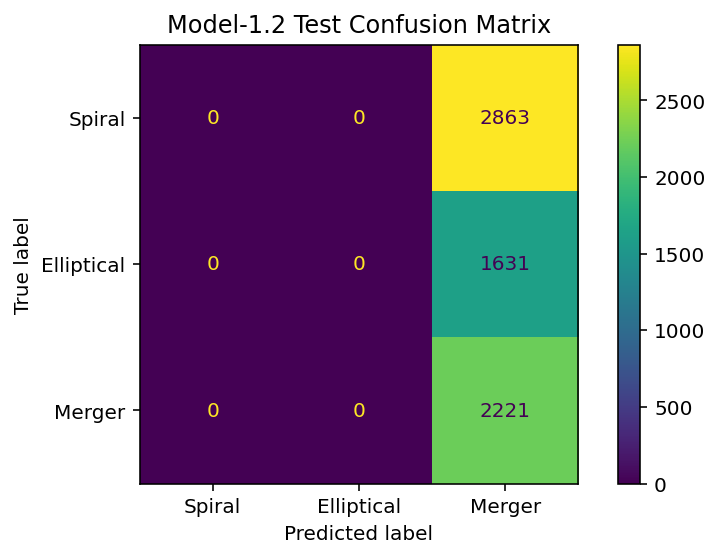

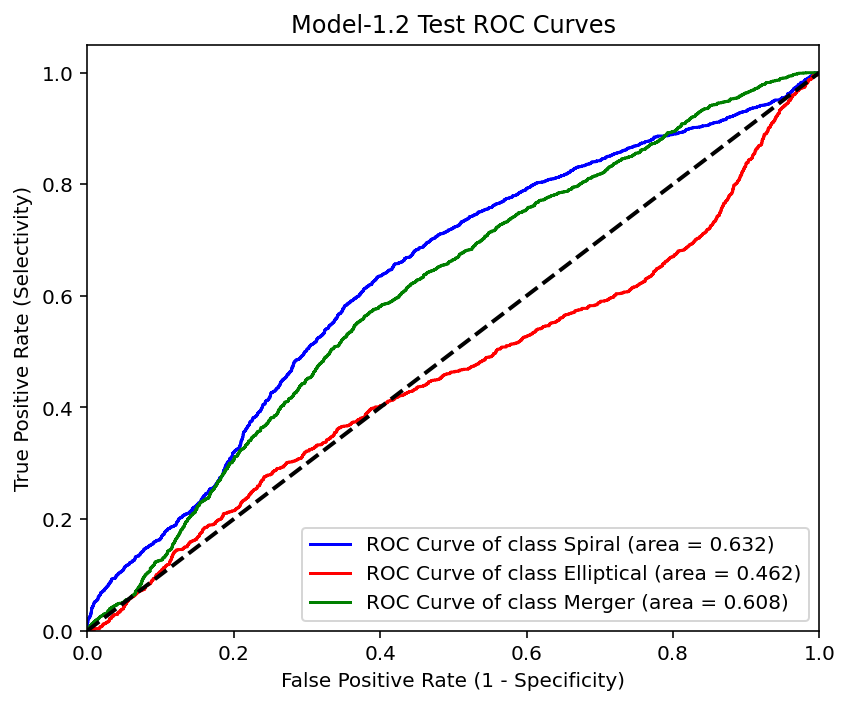

In [33]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_2.predict(X_test_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_1_2, 
              np.argmax(Y_test, axis=1), 
              np.argmax(model_1_1.predict(X_test_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_1_2.name} Test Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_1_2.name}_test_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_1_2.name} Test ROC Curves')
plt.savefig(fname=f'{model_1_2.name}_test_ROC', format='png')
plt.show()

105/105 [==============================] - 1s 10ms/step
Test:
              precision    recall  f1-score   support

      Spiral       0.62      0.20      0.30      1432
  Elliptical       0.22      0.73      0.34       815
      Merger       0.29      0.05      0.08      1108

    accuracy                           0.28      3355
   macro avg       0.38      0.33      0.24      3355
weighted avg       0.42      0.28      0.23      3355


105/105 [==============================] - 1s 10ms/step


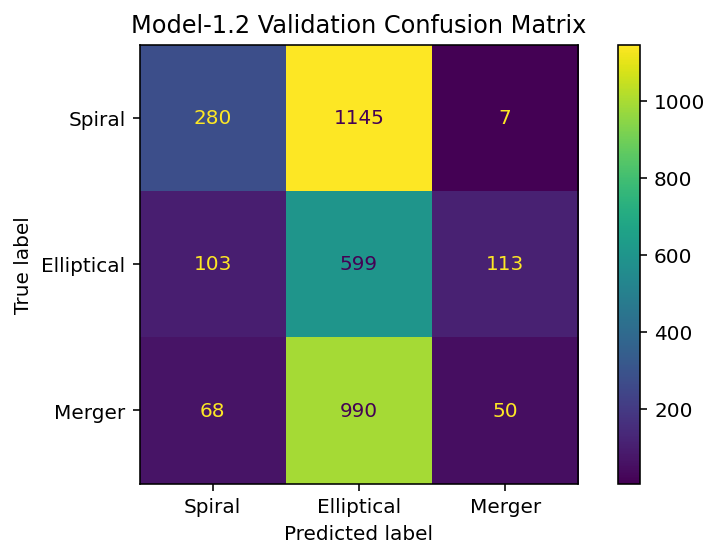

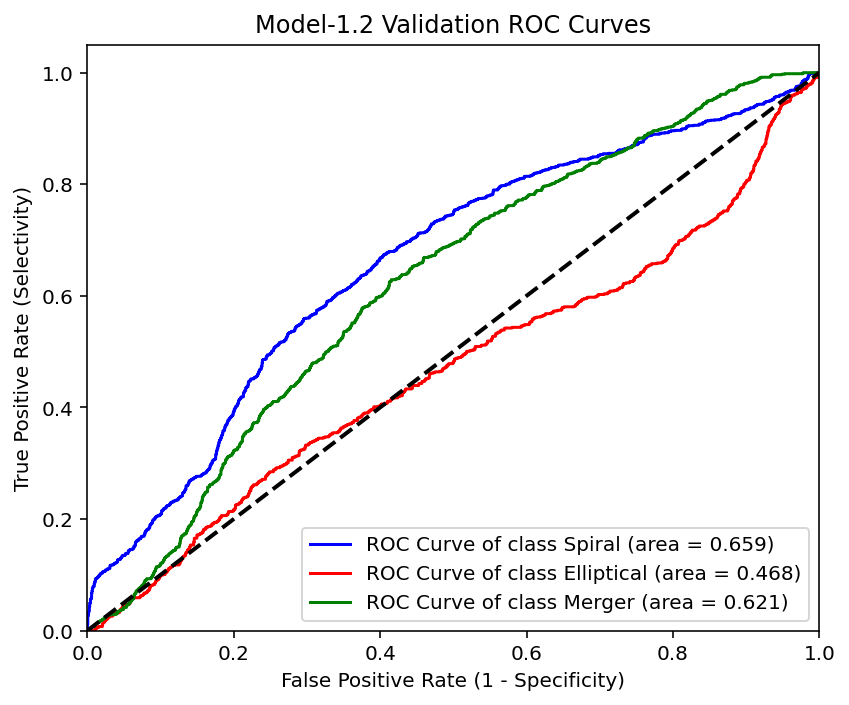

In [34]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_2.predict(X_valid_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_valid, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_1_2, 
              np.argmax(Y_valid, axis=1), 
              np.argmax(model_1_2.predict(X_valid_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_1_2.name} Validation Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_1_2.name}_validation_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_1_2.name} Validation ROC Curves')
plt.savefig(fname=f'{model_1_2.name}_validation_ROC', format='png')
plt.show()

In [35]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_2.predict(X_test_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Year 10 Test:\n" + classification_metrics + '\n')

210/210 [==============================] - 2s 9ms/step
Year 10 Test:
              precision    recall  f1-score   support

      Spiral       0.54      0.16      0.24      2863
  Elliptical       0.24      0.85      0.37      1631
      Merger       0.28      0.00      0.00      2221

    accuracy                           0.27      6715
   macro avg       0.35      0.34      0.21      6715
weighted avg       0.38      0.27      0.19      6715




### Model 1.3

Similar to DeepMerge architecture

Loss: Categorical Cross-entropy

Optimizer: Adam Weighted (Exponential decay 0.1 to 0.0001)

Uses Image Augmentation: False

Change: Dropout back to 0.1, use Adam weighted

In [54]:
## Define model architecture with the Functional API
input_shape = (3, 100, 100)
x = Input(shape=input_shape)

c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.1)(d0)

c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.1)(d1)

c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.1)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='relu', name='dense_1')(f)
z1 = Dense(32, activation='relu', name='dense_2')(z0)
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z1)

model_1_3 = Model(inputs=x, outputs=y, name="Model-1.3")

## Compile Model
b1 = 0.7
b2 = 0.8
lr = 1e-5
wd = .001
eps = 1e-8
optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd, epsilon=eps, beta_1=b1, beta_2=b2)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
compile_model(model=model_1_3, loss=loss, optimizer = optimizer)

Model: "Model-1.3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization_24 (Bat  (None, 8, 100, 100)      400       
 chNormalization)                                                
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout_24 (Dropout)        (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                         

In [55]:
## Define Callback Functions
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
        ModelCheckpoint(filepath='Y1_best_weights.h5', monitor='val_accuracy', 
                        mode='max', verbose=1, save_best_only=True)
     ] 

In [56]:
## Train Model
batch_size = 128
NUM_EPOCH = 200
history_1_3 = model_1_3.fit(X_train_1, Y_train,
                    batch_size = batch_size,
                    epochs = NUM_EPOCH,
                    validation_data = (X_valid_1, Y_valid),
                    shuffle = True,
                    class_weight = class_weights,
                    verbose = 1,
                    callbacks = es
            )

Epoch 1/200


2022-09-18 20:24:10.824825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 1.1199 - accuracy: 0.3639

2022-09-18 20:25:21.249496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.33025, saving model to Y1_best_weights.h5
184/184 [==============================] - 72s 386ms/step - loss: 1.1199 - accuracy: 0.3639 - val_loss: 1.1461 - val_accuracy: 0.3303
Epoch 2/200
184/184 [==============================] - ETA: 0s - loss: 1.0714 - accuracy: 0.4263
Epoch 2: val_accuracy did not improve from 0.33025
184/184 [==============================] - 68s 368ms/step - loss: 1.0714 - accuracy: 0.4263 - val_loss: 1.0941 - val_accuracy: 0.3303
Epoch 3/200
184/184 [==============================] - ETA: 0s - loss: 1.0625 - accuracy: 0.4518
Epoch 3: val_accuracy improved from 0.33025 to 0.41043, saving model to Y1_best_weights.h5
184/184 [==============================] - 68s 368ms/step - loss: 1.0625 - accuracy: 0.4518 - val_loss: 1.0794 - val_accuracy: 0.4104
Epoch 4/200
184/184 [==============================] - ETA: 0s - loss: 1.0583 - accuracy: 0.4711
Epoch 4: val_accuracy improved from 0.41043 to 0.42683, saving model to Y1_b

In [57]:
# Evaluate model on test sets
evaluate_model(model_1_3, X_test_1, Y_test)
evaluate_model(model_1_3, X_test_10, Y_test)
evaluate_model(model_1_3, X_test_1_sub, Y_test_sub)
evaluate_model(model_1_3, X_test_10_sub, Y_test_sub)

## Save model data
save_model_data(model_1_3, history_1_3)

210/210 [==============================] - 3s 14ms/step - loss: 1.0973 - accuracy: 0.3124
accuracy: 31.24%
210/210 [==============================] - 3s 15ms/step - loss: 1.0965 - accuracy: 0.5017
accuracy: 50.17%
5/5 [==============================] - 0s 32ms/step - loss: 1.0948 - accuracy: 0.4600
accuracy: 46.00%
5/5 [==============================] - 0s 15ms/step - loss: 1.0956 - accuracy: 0.5133
accuracy: 51.33%


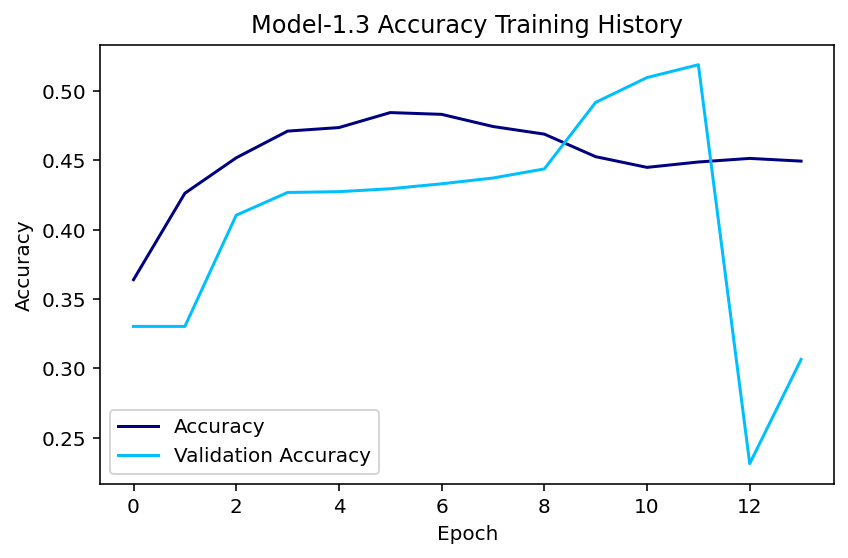

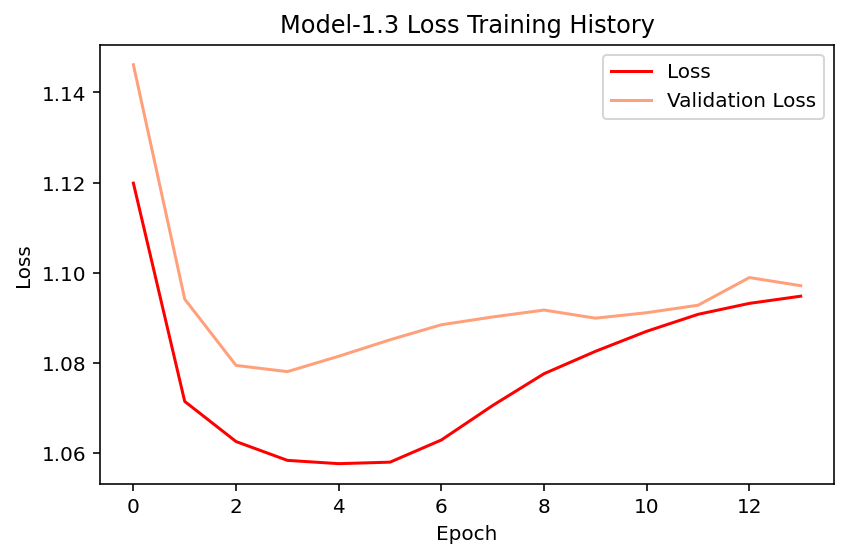

In [58]:
## Visualize training results
# Plot training history
plot_training(model_1_3, history_1_3)

2022-09-18 21:13:10.964971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 8s 11ms/step
Train:
              precision    recall  f1-score   support

      Spiral       0.61      0.09      0.16     10017
  Elliptical       0.30      0.55      0.39      5705
      Merger       0.28      0.41      0.33      7765

    accuracy                           0.31     23487
   macro avg       0.39      0.35      0.29     23487
weighted avg       0.42      0.31      0.27     23487


734/734 [==============================] - 9s 11ms/step


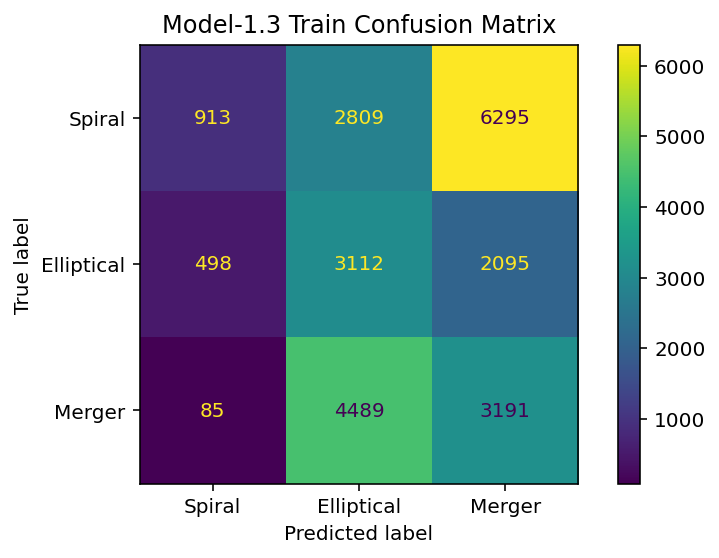

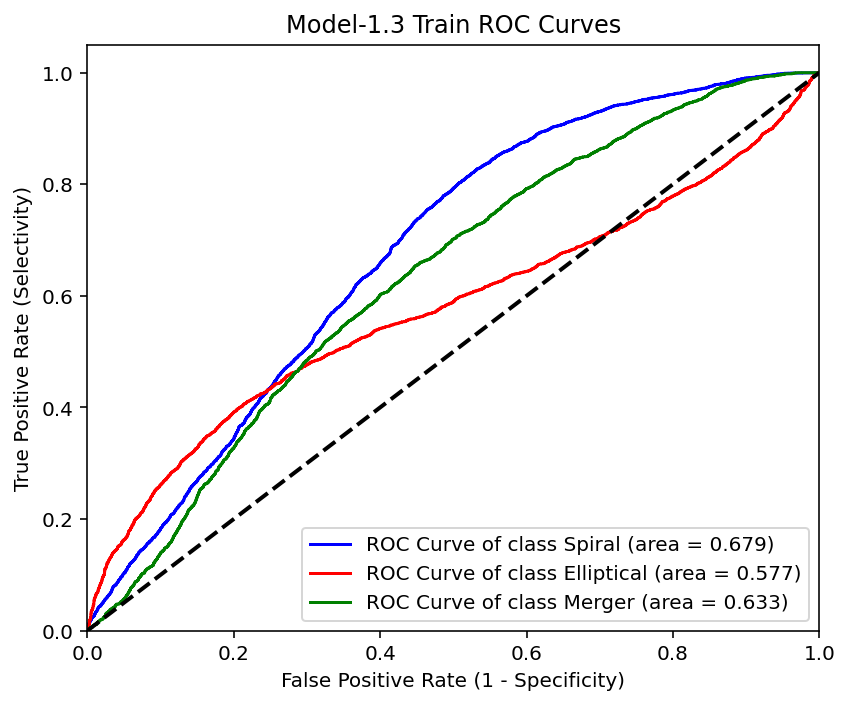

In [59]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_3.predict(X_train_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_train, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_1_3, 
              np.argmax(Y_train, axis=1), 
              np.argmax(model_1_3.predict(X_train_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_1_3.name} Train Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_1_3.name}_train_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_1_3.name} Train ROC Curves')
plt.savefig(fname=f'{model_1_3.name}_train_ROC', format='png')
plt.show()

210/210 [==============================] - 2s 11ms/step
Test:
              precision    recall  f1-score   support

      Spiral       0.61      0.10      0.17      2863
  Elliptical       0.30      0.54      0.39      1631
      Merger       0.28      0.42      0.33      2221

    accuracy                           0.31      6715
   macro avg       0.40      0.35      0.30      6715
weighted avg       0.43      0.31      0.28      6715


210/210 [==============================] - 3s 12ms/step


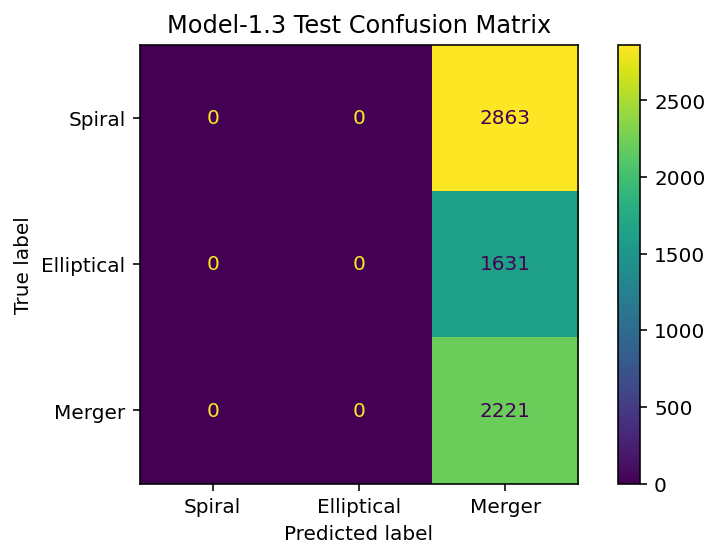

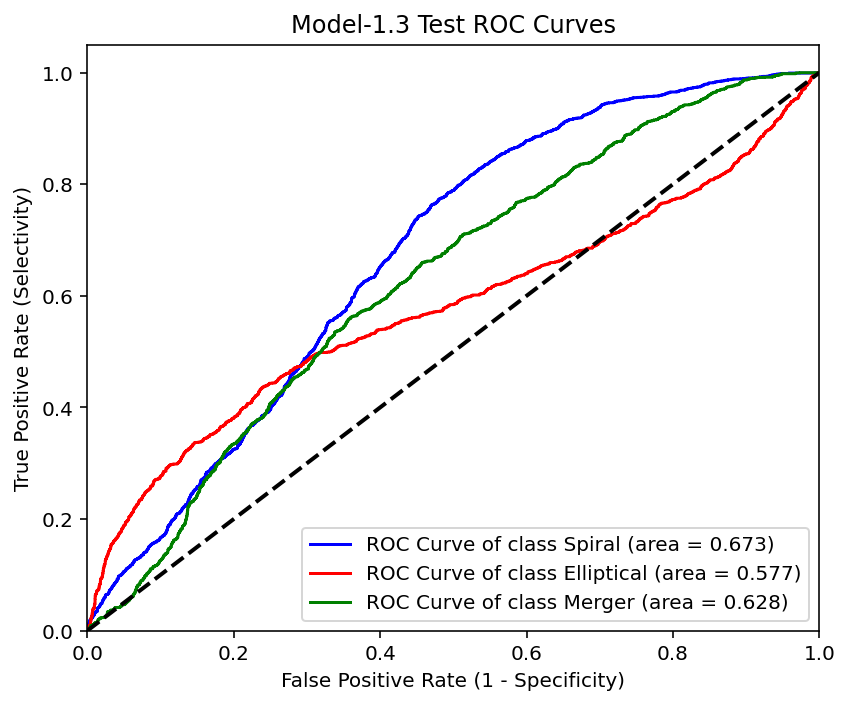

In [64]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_3.predict(X_test_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_1_3, 
              np.argmax(Y_test, axis=1), 
              np.argmax(model_1_1.predict(X_test_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_1_3.name} Test Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_1_3.name}_test_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_1_3.name} Test ROC Curves')
plt.savefig(fname=f'{model_1_3.name}_test_ROC', format='png')
plt.show()

105/105 [==============================] - 1s 11ms/step
Test:
              precision    recall  f1-score   support

      Spiral       0.63      0.08      0.15      1432
  Elliptical       0.31      0.58      0.40       815
      Merger       0.27      0.40      0.32      1108

    accuracy                           0.31      3355
   macro avg       0.40      0.35      0.29      3355
weighted avg       0.43      0.31      0.27      3355


105/105 [==============================] - 1s 11ms/step


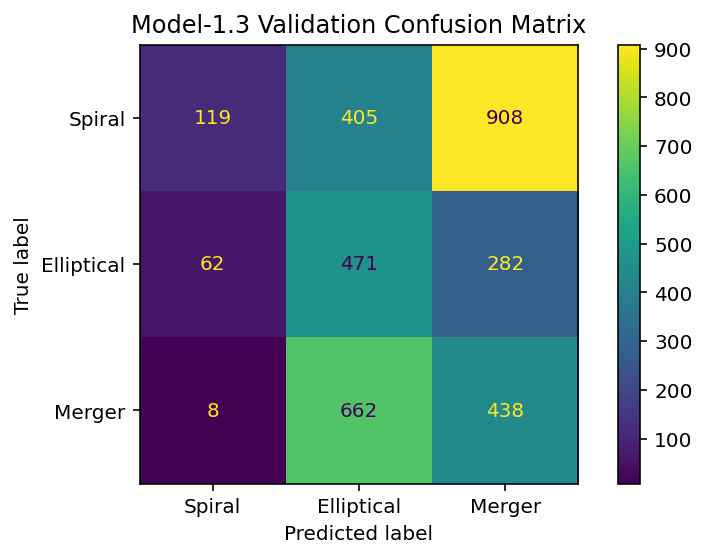

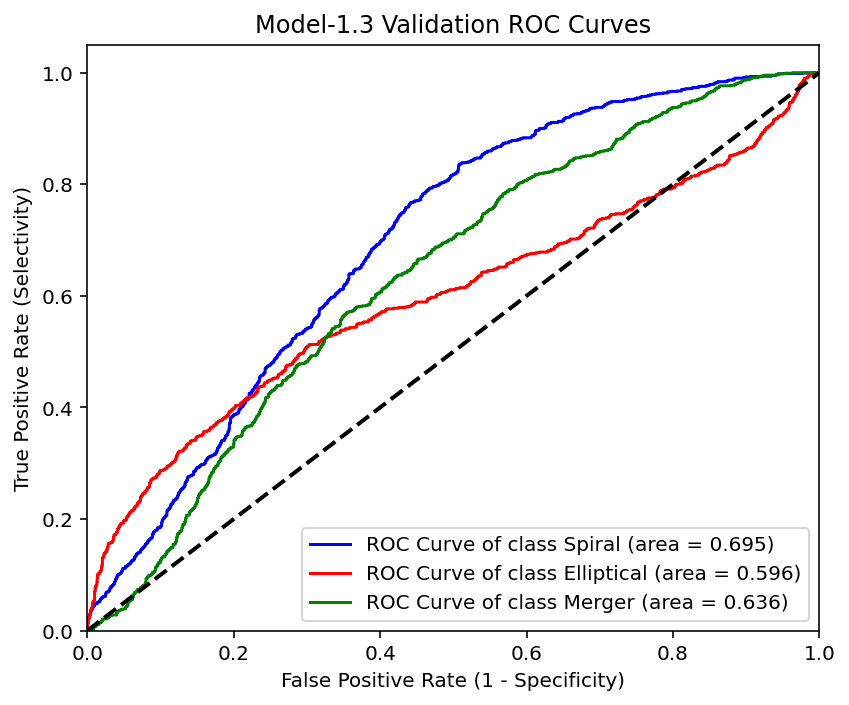

In [65]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_3.predict(X_valid_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_valid, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_1_3, 
              np.argmax(Y_valid, axis=1), 
              np.argmax(model_1_3.predict(X_valid_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_1_3.name} Validation Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_1_3.name}_validation_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_1_3.name} Validation ROC Curves')
plt.savefig(fname=f'{model_1_3.name}_validation_ROC', format='png')
plt.show()

In [63]:
model_1_3# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_3.predict(X_test_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Year 10 Test:\n" + classification_metrics + '\n')

210/210 [==============================] - 2s 11ms/step
Year 10 Test:
              precision    recall  f1-score   support

      Spiral       0.56      0.66      0.60      2863
  Elliptical       0.48      0.28      0.35      1631
      Merger       0.43      0.46      0.45      2221

    accuracy                           0.50      6715
   macro avg       0.49      0.47      0.47      6715
weighted avg       0.50      0.50      0.49      6715




### Model 1.4
Similar to DeepMerge architecture

Loss: Categorical Cross-entropy

Optimizer: Adam

Uses Image Augmentation: False

Change: Back to regular Adam optimizer. Try batch size of 64

In [14]:
## Define model architecture with the Functional API
input_shape = (3, 100, 100)
x = Input(shape=input_shape)

c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.1)(d0)

c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.1)(d1)

c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.1)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z1)

model_1_4 = Model(inputs=x, outputs=y, name="Model-1.4")

## Compile Model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
compile_model(model_1_4, loss=loss, optimizer = optimizer)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-09-19 15:21:46.913299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-19 15:21:46.914674: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "Model-1.4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization (BatchN  (None, 8, 100, 100)      400       
 ormalization)                                                   
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout (Dropout)           (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                         

In [15]:
## Define Callback Functions
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
        ModelCheckpoint(filepath='Y1_best_weights.h5', monitor='val_accuracy', 
                        mode='max', verbose=1, save_best_only=True)
      ]

In [16]:
## Train Model
batch_size = 64
NUM_EPOCH = 200
history_1_4 = model_1_4.fit(X_train_1, Y_train,
                    batch_size = batch_size,
                    epochs = NUM_EPOCH,
                    validation_data = (X_valid_1, Y_valid),
                    shuffle = True,
                    class_weight = class_weights,
                    verbose = 1,
                    callbacks = es
            )

Epoch 1/200


2022-09-19 15:22:10.050790: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-19 15:22:10.633900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


367/367 [==============================] - ETA: 0s - loss: 1.1239 - accuracy: 0.4152

2022-09-19 15:23:25.482426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.33025, saving model to Y1_best_weights.h5
367/367 [==============================] - 76s 205ms/step - loss: 1.1239 - accuracy: 0.4152 - val_loss: 6.6224 - val_accuracy: 0.3303
Epoch 2/200
367/367 [==============================] - ETA: 0s - loss: 1.0203 - accuracy: 0.4838
Epoch 2: val_accuracy did not improve from 0.33025
367/367 [==============================] - 74s 203ms/step - loss: 1.0203 - accuracy: 0.4838 - val_loss: 1.2574 - val_accuracy: 0.2623
Epoch 3/200
367/367 [==============================] - ETA: 0s - loss: 0.9650 - accuracy: 0.5252
Epoch 3: val_accuracy improved from 0.33025 to 0.34754, saving model to Y1_best_weights.h5
367/367 [==============================] - 73s 200ms/step - loss: 0.9650 - accuracy: 0.5252 - val_loss: 1.0987 - val_accuracy: 0.3475
Epoch 4/200
367/367 [==============================] - ETA: 0s - loss: 0.9435 - accuracy: 0.5408
Epoch 4: val_accuracy did not improve from 0.34754
367/367 [================

In [17]:
# Evaluate model on test sets
evaluate_model(model_1_4, X_test_1, Y_test)
evaluate_model(model_1_4, X_test_10, Y_test)
evaluate_model(model_1_4, X_test_1_sub, Y_test_sub)
evaluate_model(model_1_4, X_test_10_sub, Y_test_sub)

## Save model data
save_model_data(model_1_4, history_1_4)

210/210 [==============================] - 3s 13ms/step - loss: 1.0889 - accuracy: 0.5592
accuracy: 55.92%
210/210 [==============================] - 3s 13ms/step - loss: 1.4369 - accuracy: 0.4097
accuracy: 40.97%
5/5 [==============================] - 0s 19ms/step - loss: 0.7999 - accuracy: 0.6667
accuracy: 66.67%
5/5 [==============================] - 0s 13ms/step - loss: 1.2131 - accuracy: 0.5267
accuracy: 52.67%


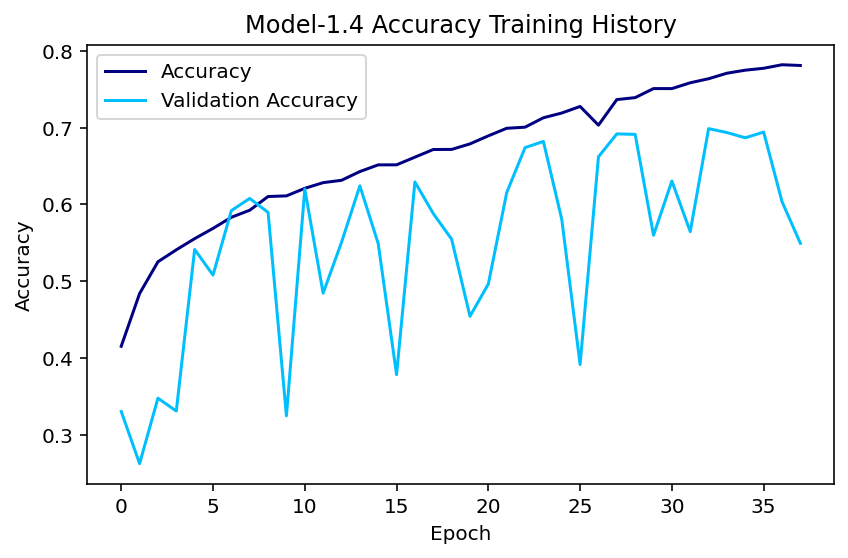

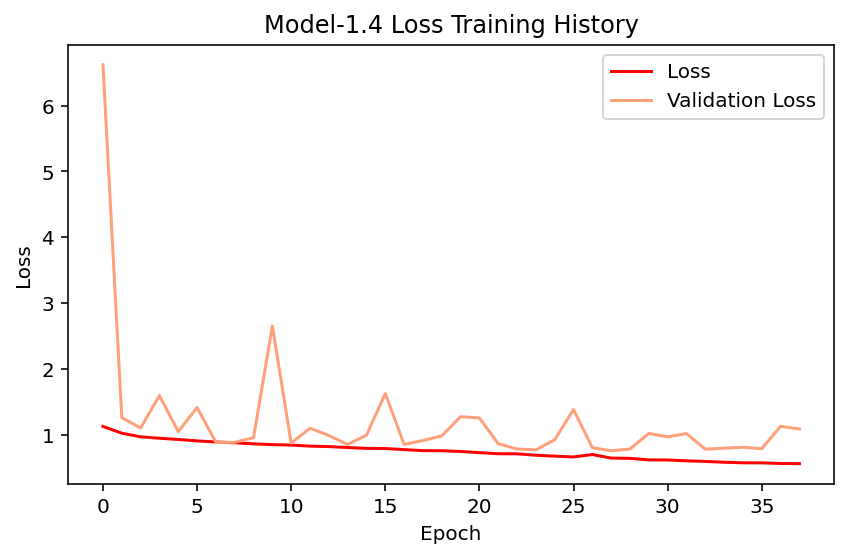

In [19]:
## Visualize training results
# Plot training history
plot_training(model_1_4, history_1_4)

  2/734 [..............................] - ETA: 47s 

2022-09-19 16:27:51.498954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 7s 9ms/step
Train:
              precision    recall  f1-score   support

      Spiral       0.93      0.47      0.63     10017
  Elliptical       0.53      0.91      0.67      5705
      Merger       0.62      0.69      0.65      7765

    accuracy                           0.65     23487
   macro avg       0.70      0.69      0.65     23487
weighted avg       0.73      0.65      0.65     23487


734/734 [==============================] - 7s 9ms/step


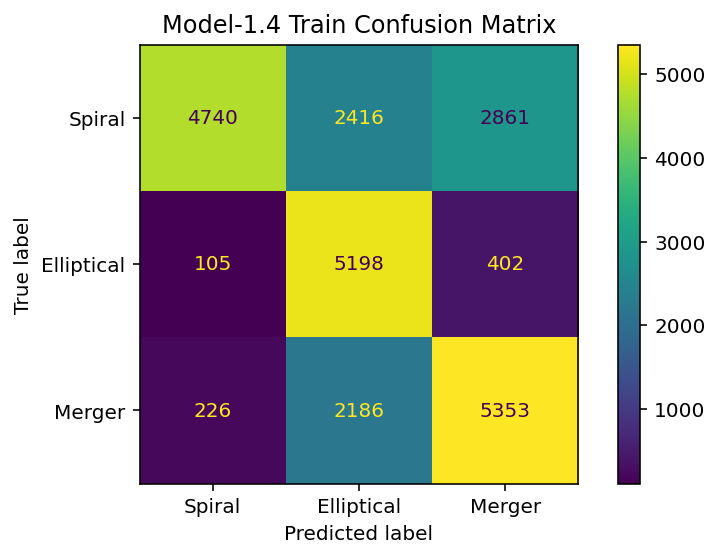

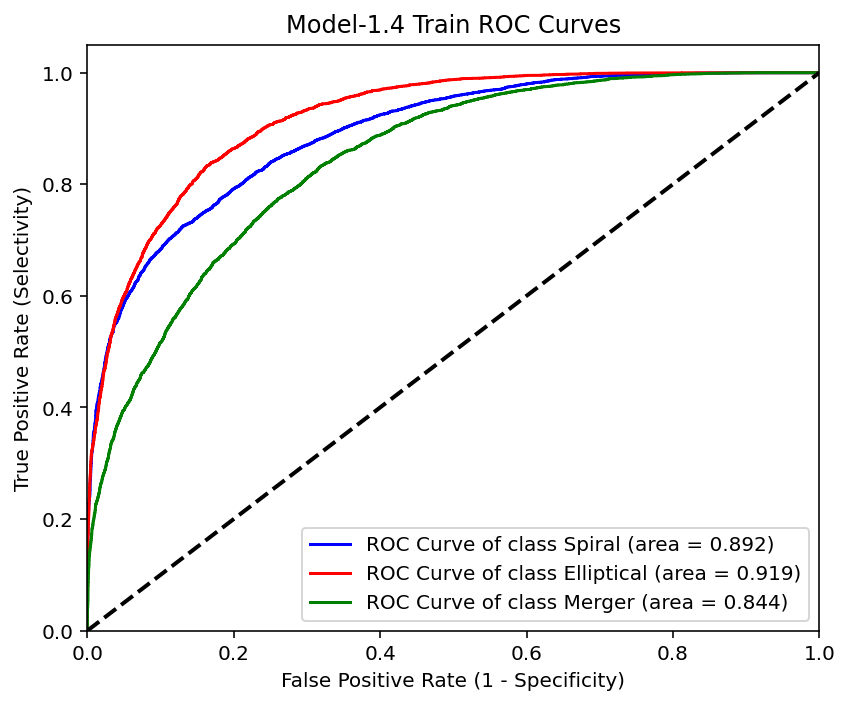

In [23]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_4.predict(X_train_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_train, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_1_4, 
              np.argmax(Y_train, axis=1), 
              np.argmax(model_1_4.predict(X_train_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_1_4.name} Train Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_1_4.name}_train_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_1_4.name} Train ROC Curves')
plt.savefig(fname=f'{model_1_4.name}_train_ROC', format='png')
plt.show()

210/210 [==============================] - 2s 11ms/step
Test:
              precision    recall  f1-score   support

      Spiral       0.86      0.40      0.55      2863
  Elliptical       0.45      0.82      0.58      1631
      Merger       0.53      0.57      0.55      2221

    accuracy                           0.56      6715
   macro avg       0.61      0.60      0.56      6715
weighted avg       0.65      0.56      0.56      6715


210/210 [==============================] - 2s 11ms/step


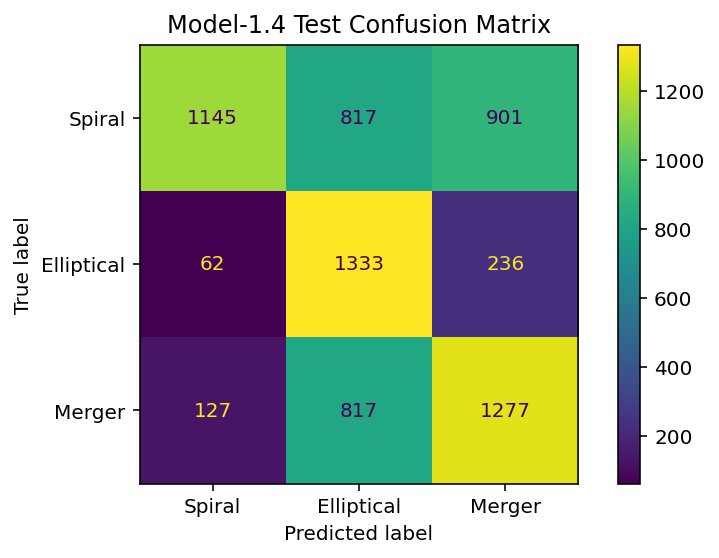

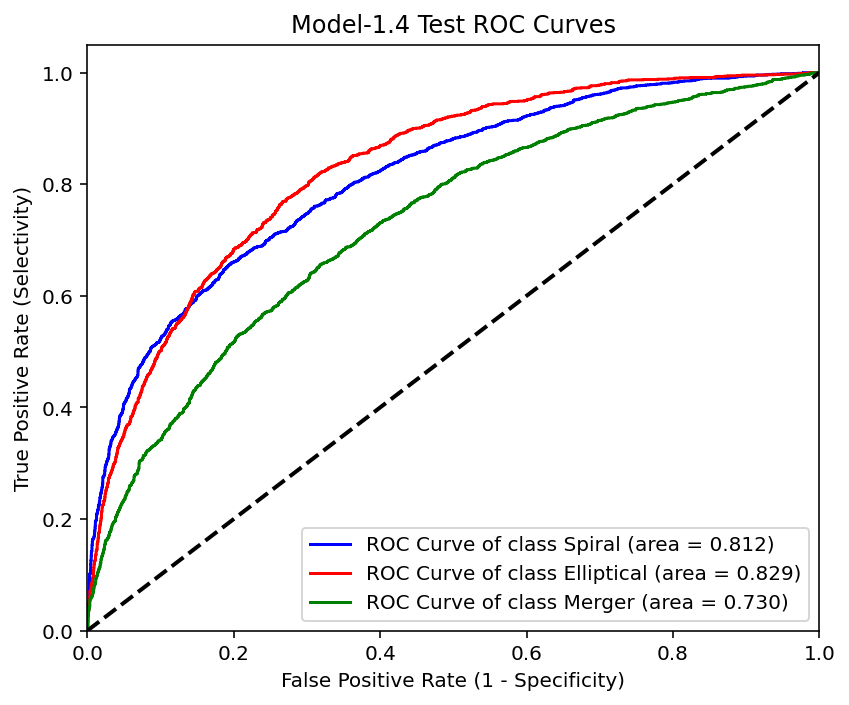

In [50]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_4.predict(X_test_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_1_4, 
              np.argmax(Y_test, axis=1), 
              np.argmax(model_1_4.predict(X_test_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_1_4.name} Test Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_1_4.name}_test_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_1_4.name} Test ROC Curves')
plt.savefig(fname=f'{model_1_4.name}_test_ROC', format='png')
plt.show()

105/105 [==============================] - 1s 11ms/step
Validation:
              precision    recall  f1-score   support

      Spiral       0.82      0.39      0.53      1432
  Elliptical       0.45      0.81      0.58       815
      Merger       0.52      0.56      0.54      1108

    accuracy                           0.55      3355
   macro avg       0.60      0.59      0.55      3355
weighted avg       0.63      0.55      0.54      3355


105/105 [==============================] - 1s 10ms/step


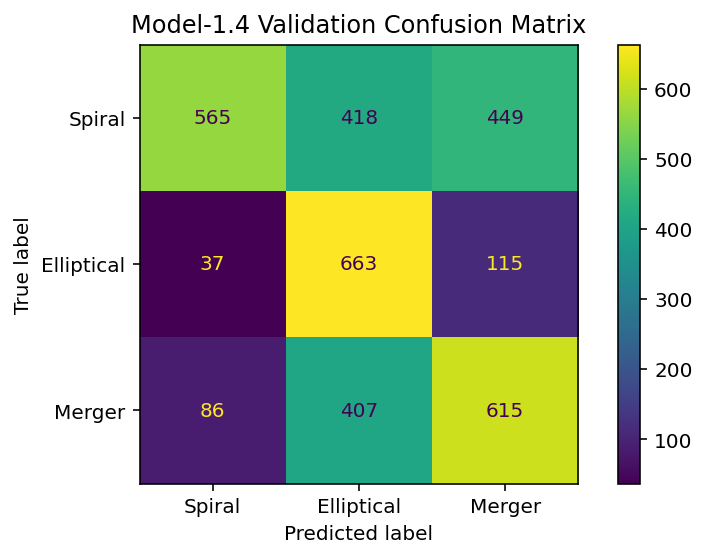

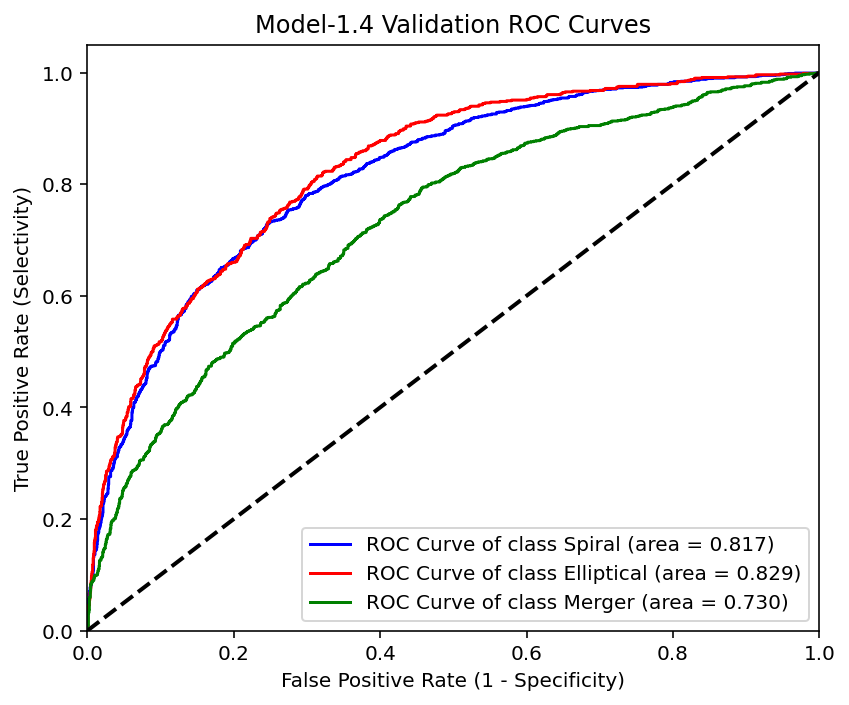

In [51]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_4.predict(X_valid_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_valid, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Validation:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_1_4, 
              np.argmax(Y_valid, axis=1), 
              np.argmax(model_1_4.predict(X_valid_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_1_4.name} Validation Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_1_4.name}_validation_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_1_4.name} Validation ROC Curves')
plt.savefig(fname=f'{model_1_4.name}_validation_ROC', format='png')
plt.show()

In [27]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_4.predict(X_test_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Year 10 Test:\n" + classification_metrics + '\n')

210/210 [==============================] - 2s 9ms/step
Year 10 Test:
              precision    recall  f1-score   support

      Spiral       0.49      0.24      0.32      2863
  Elliptical       0.40      0.51      0.45      1631
      Merger       0.38      0.56      0.45      2221

    accuracy                           0.41      6715
   macro avg       0.42      0.44      0.41      6715
weighted avg       0.43      0.41      0.40      6715




### Model 1.5
Similar to DeepMerge architecture

Loss: Categorical Cross-entropy

Optimizer: Adam w/ CylicLearningRate

Uses Image Augmentation: False

Change: Back to batch size of 128, add CyclicLearningRate

In [30]:
## Define model architecture with the Functional API
input_shape = (3, 100, 100)
x = Input(shape=input_shape)

c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.1)(d0)

c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.1)(d1)

c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.1)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z1)

model_1_5 = Model(inputs=x, outputs=y, name="Model-1.5")

## Compile Model
batch_size = 128
steps_per_epoch = len(X_train_1) // batch_size
clr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=1e-4,
    maximal_learning_rate=0.1,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size= 2 * steps_per_epoch
)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(clr)
compile_model(model_1_5, loss=loss, optimizer = optimizer)

Model: "Model-1.5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization_6 (Batc  (None, 8, 100, 100)      400       
 hNormalization)                                                 
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout_6 (Dropout)         (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                         

In [31]:
## Define Callback Functions
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
        ModelCheckpoint(filepath='Y1_best_weights.h5', monitor='val_accuracy', 
                        mode='max', verbose=1, save_best_only=True)
      ]

In [32]:
## Train model
NUM_EPOCH = 200
history_1_5 = model_1_5.fit(X_train_1, Y_train,
                    batch_size = batch_size,
                    epochs = NUM_EPOCH,
                    validation_data = (X_valid_1, Y_valid),
                    shuffle = True,
                    class_weight = class_weights,
                    verbose = 1,
                    callbacks = es
            )

Epoch 1/200


2022-09-19 16:42:30.785132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 1.2671 - accuracy: 0.3431

2022-09-19 16:43:38.974681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.42683, saving model to Y1_best_weights.h5
184/184 [==============================] - 70s 372ms/step - loss: 1.2671 - accuracy: 0.3431 - val_loss: 1.1408 - val_accuracy: 0.4268
Epoch 2/200
184/184 [==============================] - ETA: 0s - loss: 1.1258 - accuracy: 0.3284
Epoch 2: val_accuracy did not improve from 0.42683
184/184 [==============================] - 66s 360ms/step - loss: 1.1258 - accuracy: 0.3284 - val_loss: 1.1114 - val_accuracy: 0.3303
Epoch 3/200
184/184 [==============================] - ETA: 0s - loss: 1.1070 - accuracy: 0.3096
Epoch 3: val_accuracy did not improve from 0.42683
184/184 [==============================] - 66s 360ms/step - loss: 1.1070 - accuracy: 0.3096 - val_loss: 1.1046 - val_accuracy: 0.2429
Epoch 4/200
184/184 [==============================] - ETA: 0s - loss: 1.1033 - accuracy: 0.3482
Epoch 4: val_accuracy did not improve from 0.42683
184/184 [==============================] - 68s 367ms/step - loss:

In [33]:
# Evaluate model on test sets
evaluate_model(model_1_5, X_test_1, Y_test)
evaluate_model(model_1_5, X_test_10, Y_test)
evaluate_model(model_1_5, X_test_1_sub, Y_test_sub)
evaluate_model(model_1_5, X_test_10_sub, Y_test_sub)

## Save model data
save_model_data(model_1_5, history_1_5)

210/210 [==============================] - 3s 15ms/step - loss: 1.0979 - accuracy: 0.4264
accuracy: 42.64%
210/210 [==============================] - 3s 14ms/step - loss: 1.0979 - accuracy: 0.4264
accuracy: 42.64%
5/5 [==============================] - 0s 21ms/step - loss: 1.0994 - accuracy: 0.3333
accuracy: 33.33%
5/5 [==============================] - 0s 15ms/step - loss: 1.0994 - accuracy: 0.3333
accuracy: 33.33%


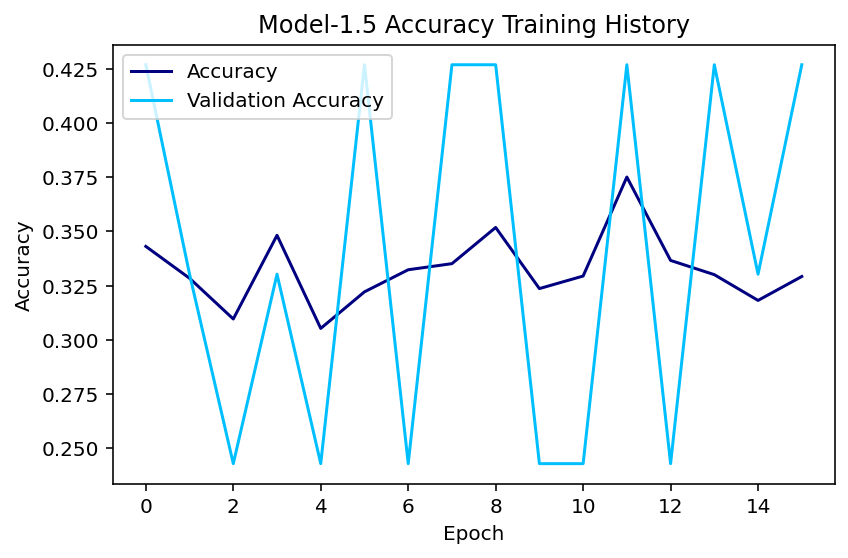

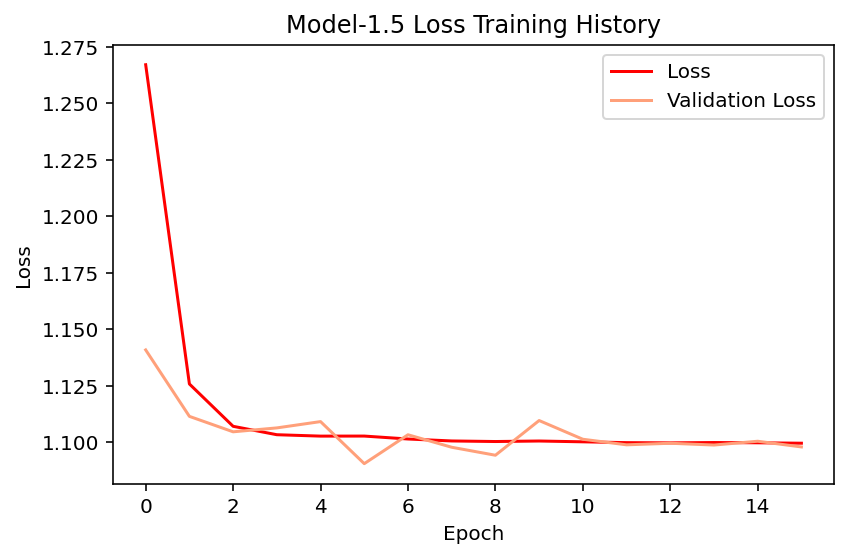

In [34]:
## Visualize training results
# Plot training history
plot_training(model_1_5, history_1_5)

  1/734 [..............................] - ETA: 3:05

2022-09-19 17:01:51.083942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 8s 11ms/step
Train:
              precision    recall  f1-score   support

      Spiral       0.43      1.00      0.60     10017
  Elliptical       0.00      0.00      0.00      5705
      Merger       0.00      0.00      0.00      7765

    accuracy                           0.43     23487
   macro avg       0.14      0.33      0.20     23487
weighted avg       0.18      0.43      0.26     23487


734/734 [==============================] - 8s 11ms/step


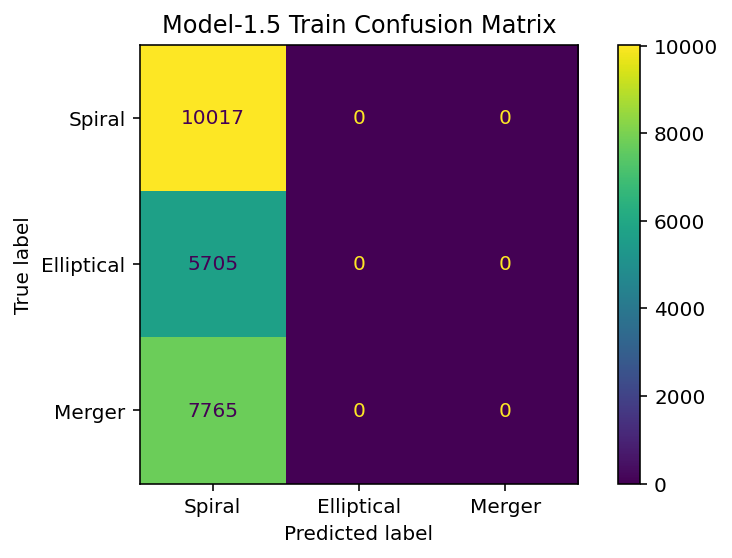

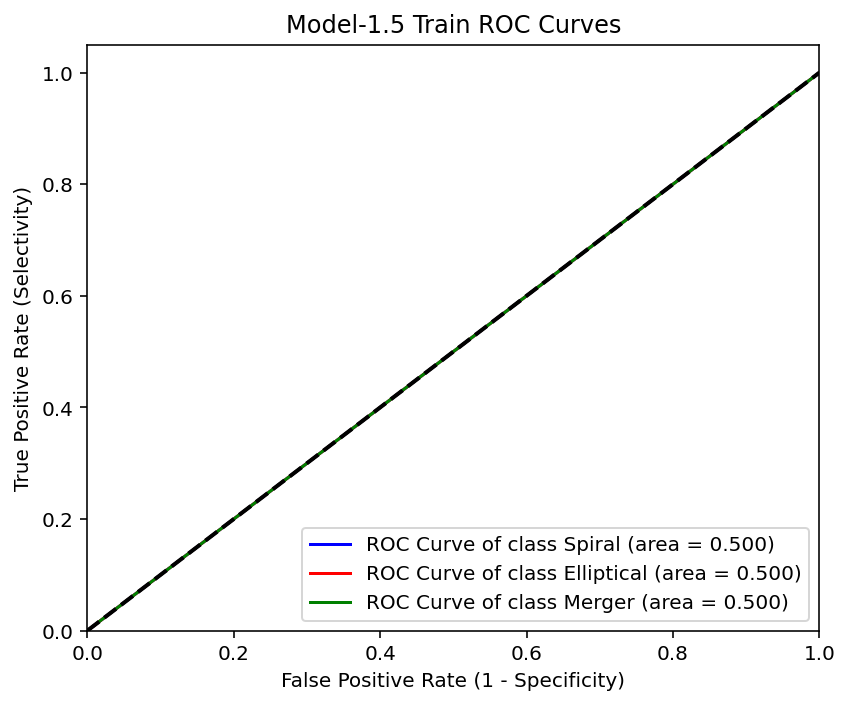

In [35]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_5.predict(X_train_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_train, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_1_5, 
              np.argmax(Y_train, axis=1), 
              np.argmax(model_1_5.predict(X_train_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_1_5.name} Train Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_1_5.name}_train_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_1_5.name} Train ROC Curves')
plt.savefig(fname=f'{model_1_5.name}_train_ROC', format='png')
plt.show()

210/210 [==============================] - 2s 10ms/step
Test:
              precision    recall  f1-score   support

      Spiral       0.43      1.00      0.60      2863
  Elliptical       0.00      0.00      0.00      1631
      Merger       0.00      0.00      0.00      2221

    accuracy                           0.43      6715
   macro avg       0.14      0.33      0.20      6715
weighted avg       0.18      0.43      0.25      6715


210/210 [==============================] - 2s 9ms/step


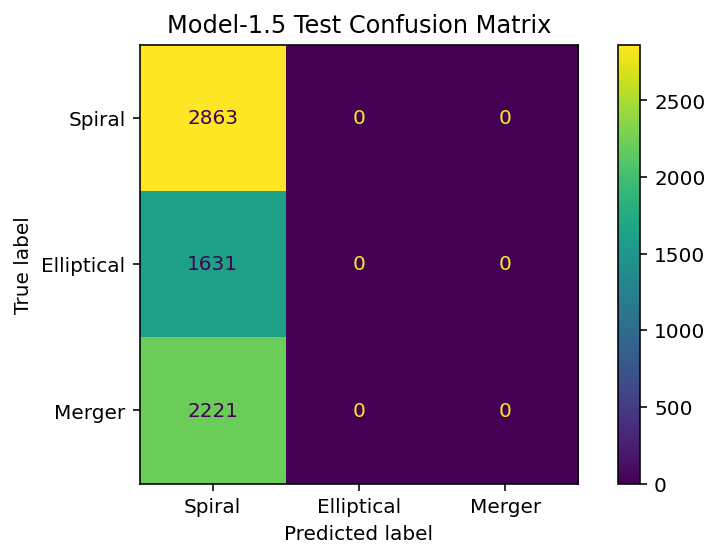

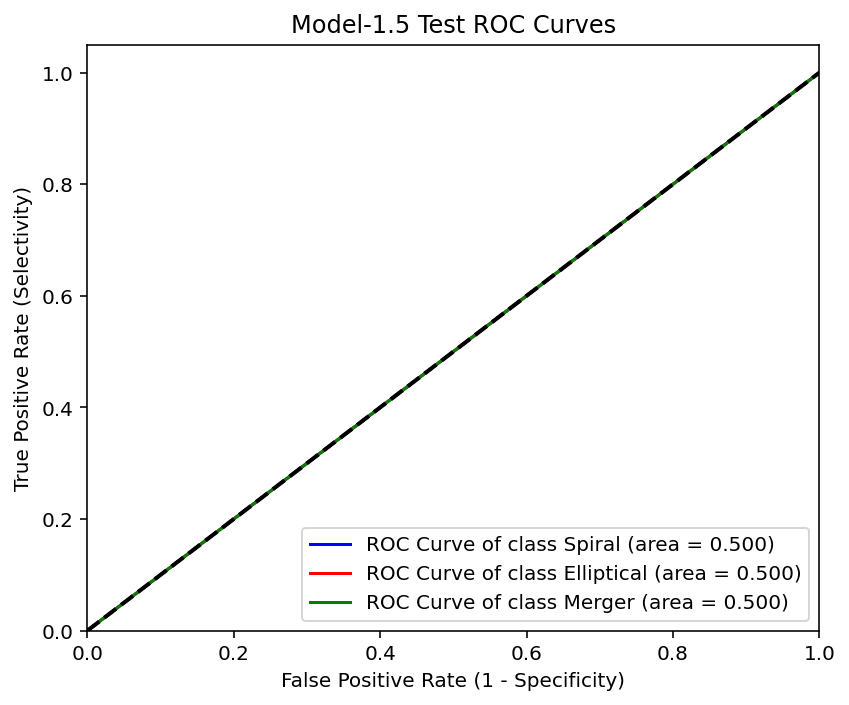

In [36]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_5.predict(X_test_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_1_5, 
              np.argmax(Y_test, axis=1), 
              np.argmax(model_1_5.predict(X_test_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_1_5.name} Test Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_1_5.name}_test_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_1_5.name} Test ROC Curves')
plt.savefig(fname=f'{model_1_5.name}_test_ROC', format='png')
plt.show()

105/105 [==============================] - 1s 11ms/step
Validation:
              precision    recall  f1-score   support

      Spiral       0.43      1.00      0.60      1432
  Elliptical       0.00      0.00      0.00       815
      Merger       0.00      0.00      0.00      1108

    accuracy                           0.43      3355
   macro avg       0.14      0.33      0.20      3355
weighted avg       0.18      0.43      0.26      3355


105/105 [==============================] - 1s 11ms/step


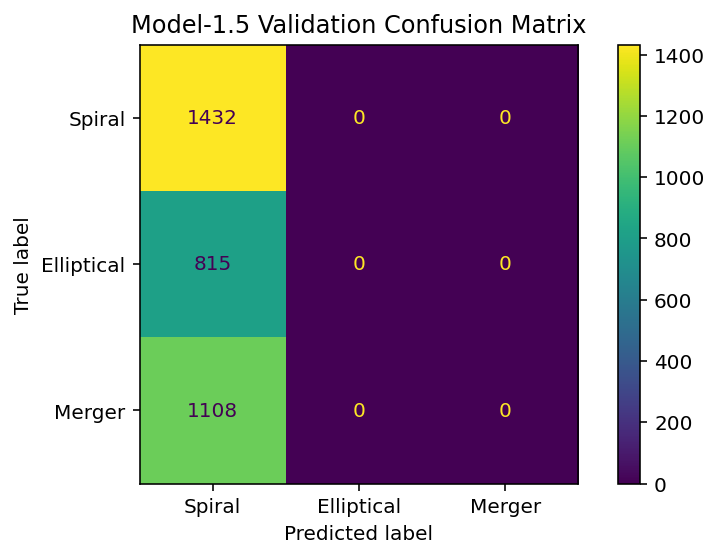

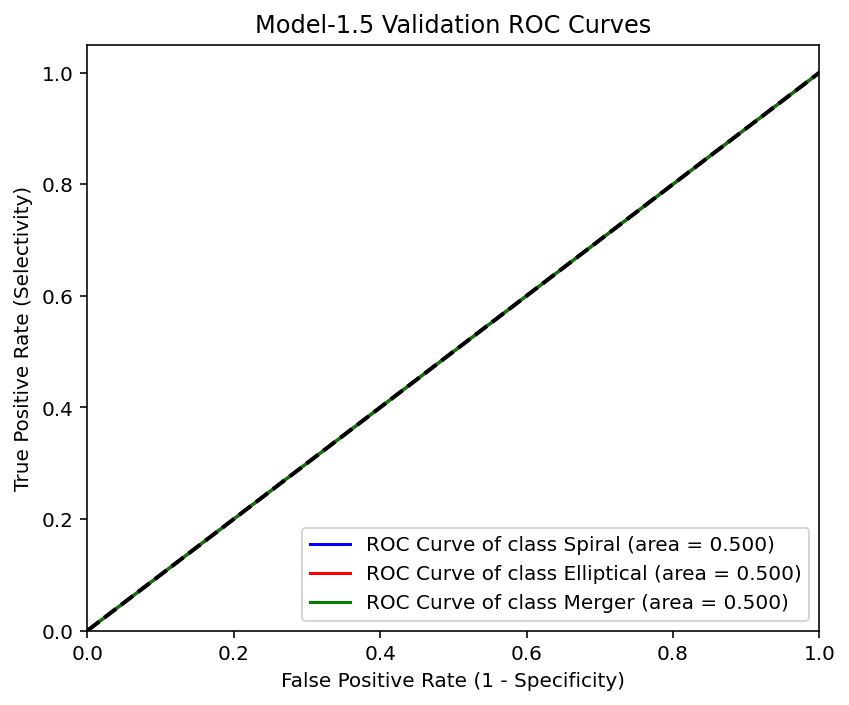

In [52]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_5.predict(X_valid_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_valid, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Validation:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_1_5, 
              np.argmax(Y_valid, axis=1), 
              np.argmax(model_1_5.predict(X_valid_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_1_5.name} Validation Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_1_5.name}_validation_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_1_5.name} Validation ROC Curves')
plt.savefig(fname=f'{model_1_5.name}_validation_ROC', format='png')
plt.show()

In [38]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_1_5.predict(X_test_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Year 10 Test:\n" + classification_metrics + '\n')

210/210 [==============================] - 2s 9ms/step
Year 10 Test:
              precision    recall  f1-score   support

      Spiral       0.43      1.00      0.60      2863
  Elliptical       0.00      0.00      0.00      1631
      Merger       0.00      0.00      0.00      2221

    accuracy                           0.43      6715
   macro avg       0.14      0.33      0.20      6715
weighted avg       0.18      0.43      0.25      6715




### Model 2
Deepening architecture from DeepMerge

Loss: Categorical Cross-entropy

Optimizer: Adam

Uses Image Augmentation: False

Change: Back to regular Adam, deepen architecture by 1 layer

In [39]:
## Define model architecture with the Functional API
input_shape = (3, 100, 100)
x = Input(shape=input_shape)

c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.1)(d0)

c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.1)(d1)

c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.1)(d2)

c3 = Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_4')(e2)
b3 = BatchNormalization()(c3)
d3 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_4')(b3)
e3 = Dropout(0.1)(d3)

f = Flatten()(e3)
z0 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z1)

model_2 = Model(inputs=x, outputs=y, name="Model-2")

## Compile Model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
compile_model(model_2, loss=loss, optimizer = optimizer)

Model: "Model-2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization_9 (Batc  (None, 8, 100, 100)      400       
 hNormalization)                                                 
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout_9 (Dropout)         (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                           

In [40]:
## Define Callback Functions
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
        ModelCheckpoint(filepath='Y1_best_weights.h5', monitor='val_accuracy', 
                        mode='max', verbose=1, save_best_only=True)
      ]

In [41]:
## Train model
batch_size = 128
NUM_EPOCH = 200
history_2 = model_2.fit(X_train_1, Y_train,
                    batch_size = batch_size,
                    epochs = NUM_EPOCH,
                    validation_data = (X_valid_1, Y_valid),
                    shuffle = True,
                    class_weight = class_weights,
                    verbose = 1,
                    callbacks = es
            )

Epoch 1/200


2022-09-19 17:10:59.489907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 1.0929 - accuracy: 0.4471

2022-09-19 17:12:09.062815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.33025, saving model to Y1_best_weights.h5
184/184 [==============================] - 71s 378ms/step - loss: 1.0929 - accuracy: 0.4471 - val_loss: 2.9489 - val_accuracy: 0.3303
Epoch 2/200
184/184 [==============================] - ETA: 0s - loss: 1.0573 - accuracy: 0.4877
Epoch 2: val_accuracy improved from 0.33025 to 0.34545, saving model to Y1_best_weights.h5
184/184 [==============================] - 67s 365ms/step - loss: 1.0573 - accuracy: 0.4877 - val_loss: 2.0070 - val_accuracy: 0.3455
Epoch 3/200
184/184 [==============================] - ETA: 0s - loss: 1.0411 - accuracy: 0.4901
Epoch 3: val_accuracy did not improve from 0.34545
184/184 [==============================] - 67s 363ms/step - loss: 1.0411 - accuracy: 0.4901 - val_loss: 1.6652 - val_accuracy: 0.2232
Epoch 4/200
184/184 [==============================] - ETA: 0s - loss: 1.0220 - accuracy: 0.5060
Epoch 4: val_accuracy improved from 0.34545 to 0.51923, saving model to Y1_b

In [42]:
# Evaluate model on test sets
evaluate_model(model_2, X_test_1, Y_test)
evaluate_model(model_2, X_test_10, Y_test)
evaluate_model(model_2, X_test_1_sub, Y_test_sub)
evaluate_model(model_2, X_test_10_sub, Y_test_sub)

## Save model data
save_model_data(model_2, history_2)

210/210 [==============================] - 3s 16ms/step - loss: 0.8325 - accuracy: 0.6322
accuracy: 63.22%
210/210 [==============================] - 4s 16ms/step - loss: 1.1292 - accuracy: 0.6037
accuracy: 60.37%
5/5 [==============================] - 0s 41ms/step - loss: 0.6975 - accuracy: 0.6933
accuracy: 69.33%
5/5 [==============================] - 0s 16ms/step - loss: 1.1996 - accuracy: 0.6133
accuracy: 61.33%


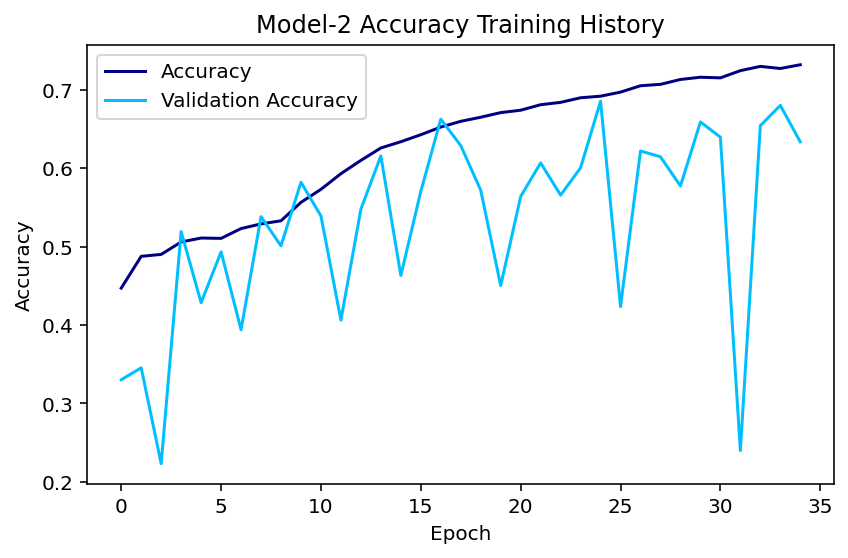

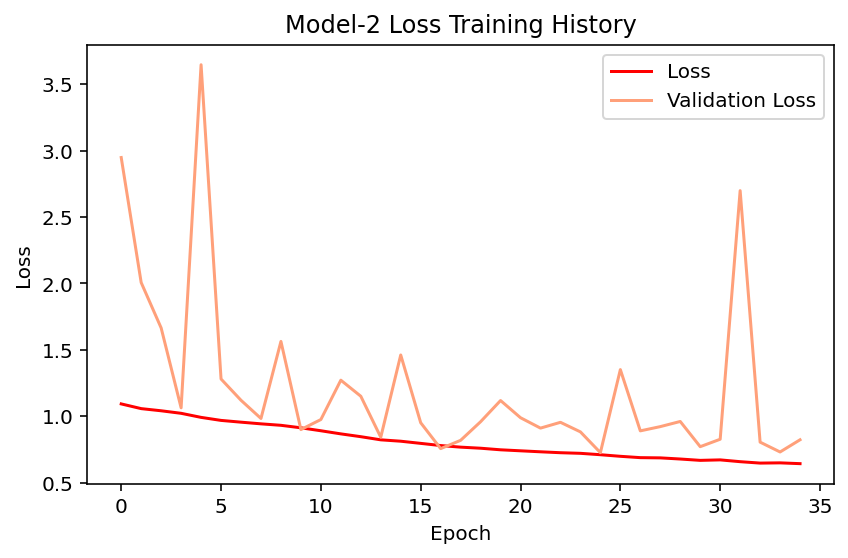

In [43]:
## Visualize training results
# Plot training history
plot_training(model_2, history_2)

2022-09-19 17:53:41.686214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 9s 12ms/step
Train:
              precision    recall  f1-score   support

      Spiral       0.70      0.78      0.74     10017
  Elliptical       0.61      0.58      0.59      5705
      Merger       0.70      0.62      0.66      7765

    accuracy                           0.68     23487
   macro avg       0.67      0.66      0.66     23487
weighted avg       0.68      0.68      0.68     23487


734/734 [==============================] - 9s 12ms/step


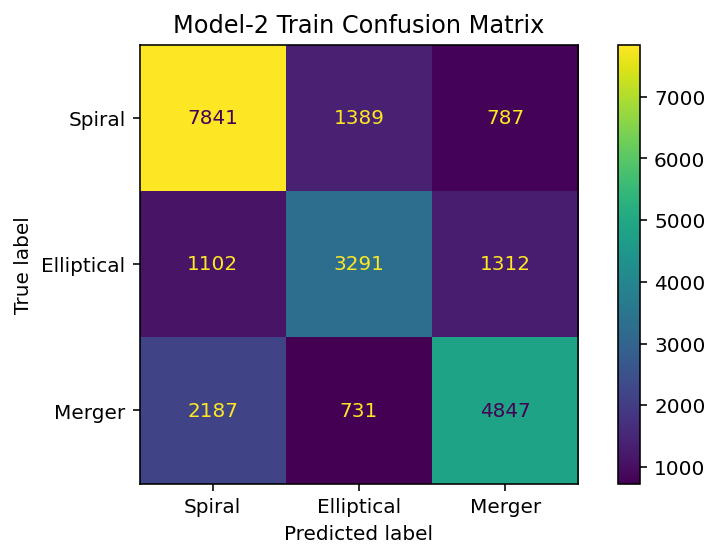

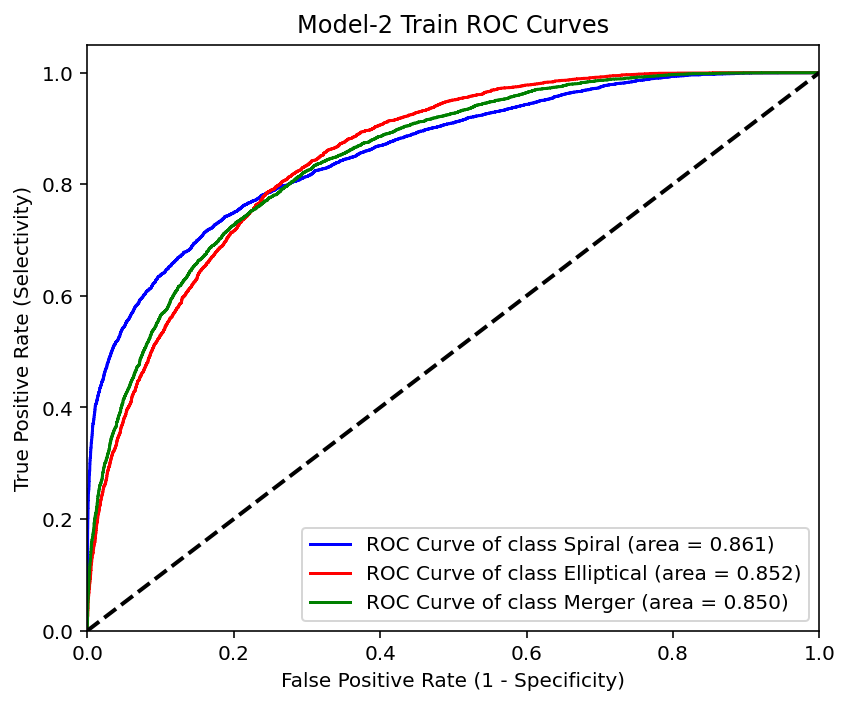

In [44]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_2.predict(X_train_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_train, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_2, 
              np.argmax(Y_train, axis=1), 
              np.argmax(model_2.predict(X_train_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_2.name} Train Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_2.name}_train_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_2.name} Train ROC Curves')
plt.savefig(fname=f'{model_2.name}_train_ROC', format='png')
plt.show()

210/210 [==============================] - 2s 12ms/step
Test:
              precision    recall  f1-score   support

      Spiral       0.68      0.75      0.71      2863
  Elliptical       0.55      0.52      0.53      1631
      Merger       0.63      0.56      0.59      2221

    accuracy                           0.63      6715
   macro avg       0.62      0.61      0.61      6715
weighted avg       0.63      0.63      0.63      6715


210/210 [==============================] - 2s 11ms/step


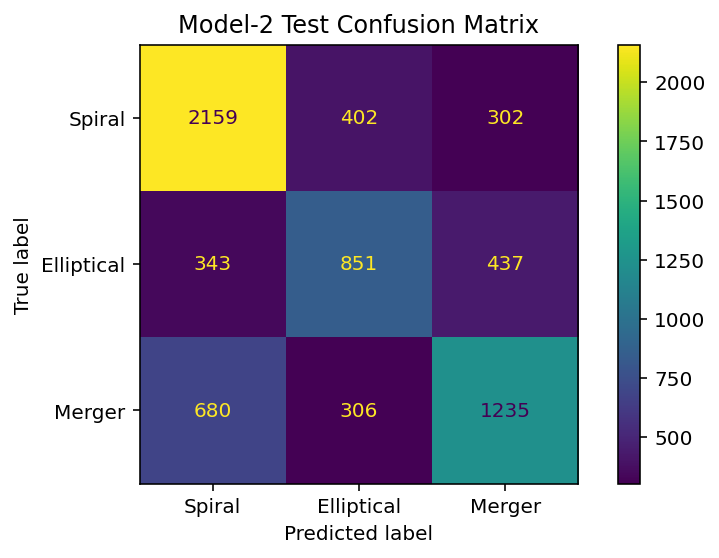

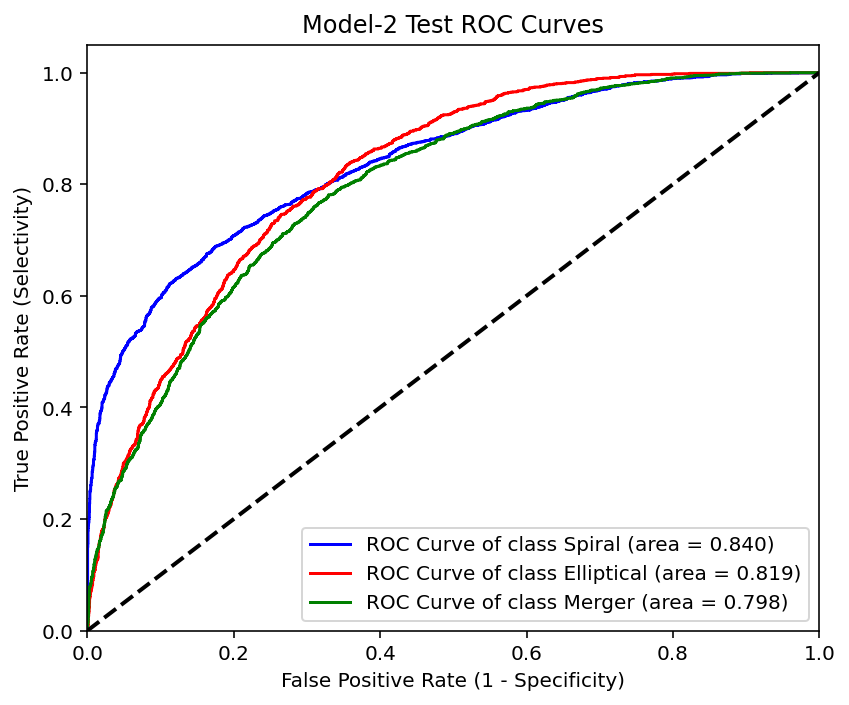

In [53]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_2.predict(X_test_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_2, 
              np.argmax(Y_test, axis=1), 
              np.argmax(model_2.predict(X_test_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_2.name} Test Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_2.name}_test_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_2.name} Test ROC Curves')
plt.savefig(fname=f'{model_2.name}_test_ROC', format='png')
plt.show()

105/105 [==============================] - 1s 11ms/step
Validation:
              precision    recall  f1-score   support

      Spiral       0.68      0.75      0.72      1432
  Elliptical       0.54      0.48      0.51       815
      Merger       0.62      0.59      0.61      1108

    accuracy                           0.63      3355
   macro avg       0.62      0.61      0.61      3355
weighted avg       0.63      0.63      0.63      3355


105/105 [==============================] - 1s 11ms/step


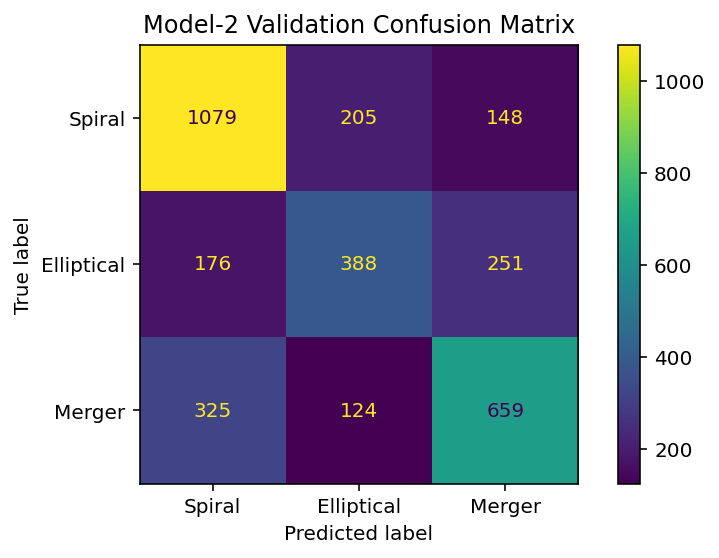

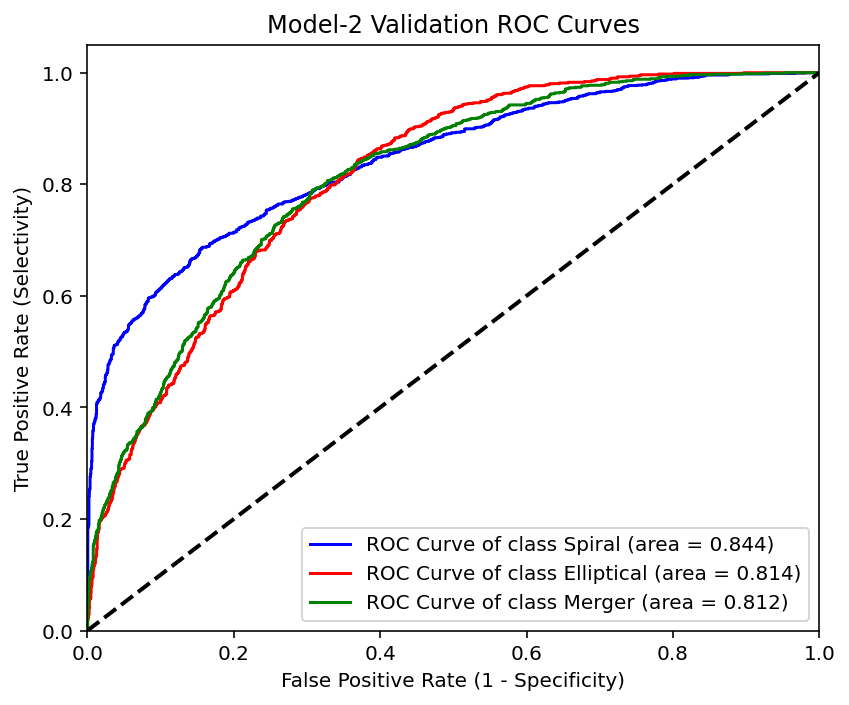

In [56]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_2.predict(X_valid_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_valid, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Validation:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_2, 
              np.argmax(Y_valid, axis=1), 
              np.argmax(model_2.predict(X_valid_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_2.name} Validation Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_2.name}_validation_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_2.name} Validation ROC Curves')
plt.savefig(fname=f'{model_2.name}_validation_ROC', format='png')
plt.show()

In [55]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_2.predict(X_test_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Year 10 Test:\n" + classification_metrics + '\n')

210/210 [==============================] - 2s 12ms/step
Year 10 Test:
              precision    recall  f1-score   support

      Spiral       0.58      0.88      0.70      2863
  Elliptical       0.58      0.26      0.36      1631
      Merger       0.68      0.50      0.58      2221

    accuracy                           0.60      6715
   macro avg       0.61      0.55      0.54      6715
weighted avg       0.61      0.60      0.58      6715




### Model 3
Similar to DeepMerge architecture but added pooling padding

Loss: Categorical Cross-entropy

Optimizer: Adam

Uses Image Augmentation: False

Change: Back to Model 1 architecture; try padding in pooling

In [13]:
## Define model architecture with the Functional API
input_shape = (3, 100, 100)
x = Input(shape=input_shape)

c0 = Conv2D(8, kernel_size=(5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.1)(d0)

c1 = Conv2D(16, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.1)(d1)

c2 = Conv2D(32, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.1)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z1)

model_3 = Model(inputs=x, outputs=y, name="Model-3")

## Compile Model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
compile_model(model_3, loss=loss, optimizer = optimizer)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-10-06 13:38:19.376331: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-06 13:38:19.377594: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "Model-3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization (BatchN  (None, 8, 100, 100)      400       
 ormalization)                                                   
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout (Dropout)           (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                           

In [14]:
## Define Callback Functions
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
        ModelCheckpoint(filepath='Y1_best_weights.h5', monitor='val_accuracy', 
                        mode='max', verbose=1, save_best_only=True)
      ]

In [15]:
## Train model
batch_size = 128
NUM_EPOCH = 200
history_3 = model_3.fit(X_train_1, Y_train,
                    batch_size = batch_size,
                    epochs = NUM_EPOCH,
                    validation_data = (X_valid_1, Y_valid),
                    shuffle = True,
                    class_weight = class_weights,
                    verbose = 1,
                    callbacks = es
            )

Epoch 1/200


2022-10-06 13:38:56.732787: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-06 13:38:57.324623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 1.1560 - accuracy: 0.3460

2022-10-06 13:40:06.011158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.32996, saving model to Y1_best_weights.h5
184/184 [==============================] - 70s 376ms/step - loss: 1.1560 - accuracy: 0.3460 - val_loss: 1.1048 - val_accuracy: 0.3300
Epoch 2/200
184/184 [==============================] - ETA: 0s - loss: 1.0868 - accuracy: 0.4289
Epoch 2: val_accuracy improved from 0.32996 to 0.33025, saving model to Y1_best_weights.h5
184/184 [==============================] - 67s 363ms/step - loss: 1.0868 - accuracy: 0.4289 - val_loss: 3.2027 - val_accuracy: 0.3303
Epoch 3/200
184/184 [==============================] - ETA: 0s - loss: 1.0592 - accuracy: 0.4829
Epoch 3: val_accuracy improved from 0.33025 to 0.34039, saving model to Y1_best_weights.h5
184/184 [==============================] - 67s 363ms/step - loss: 1.0592 - accuracy: 0.4829 - val_loss: 1.3762 - val_accuracy: 0.3404
Epoch 4/200
184/184 [==============================] - ETA: 0s - loss: 1.0478 - accuracy: 0.4837
Epoch 4: val_accuracy did not improv

In [16]:
# Evaluate model on test sets
evaluate_model(model_3, X_test_1, Y_test)
evaluate_model(model_3, X_test_10, Y_test)
evaluate_model(model_3, X_test_1_sub, Y_test_sub)
evaluate_model(model_3, X_test_10_sub, Y_test_sub)

## Save model data
save_model_data(model_3, history_3)

210/210 [==============================] - 4s 19ms/step - loss: 1.0003 - accuracy: 0.6182
accuracy: 61.82%
210/210 [==============================] - 3s 13ms/step - loss: 2.3132 - accuracy: 0.4472
accuracy: 44.72%
5/5 [==============================] - 0s 19ms/step - loss: 1.1286 - accuracy: 0.6000
accuracy: 60.00%
5/5 [==============================] - 0s 22ms/step - loss: 2.5645 - accuracy: 0.3533
accuracy: 35.33%


INFO:tensorflow:Assets written to: Model-3.json/assets


INFO:tensorflow:Assets written to: Model-3.json/assets


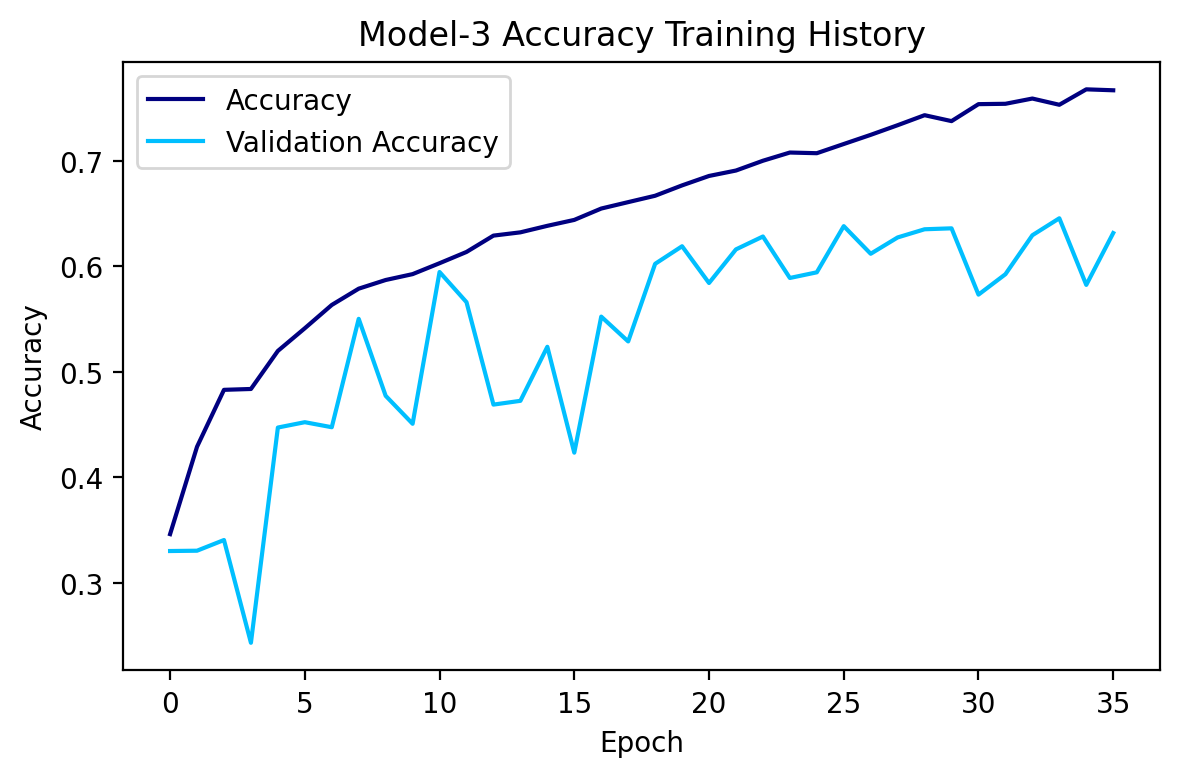

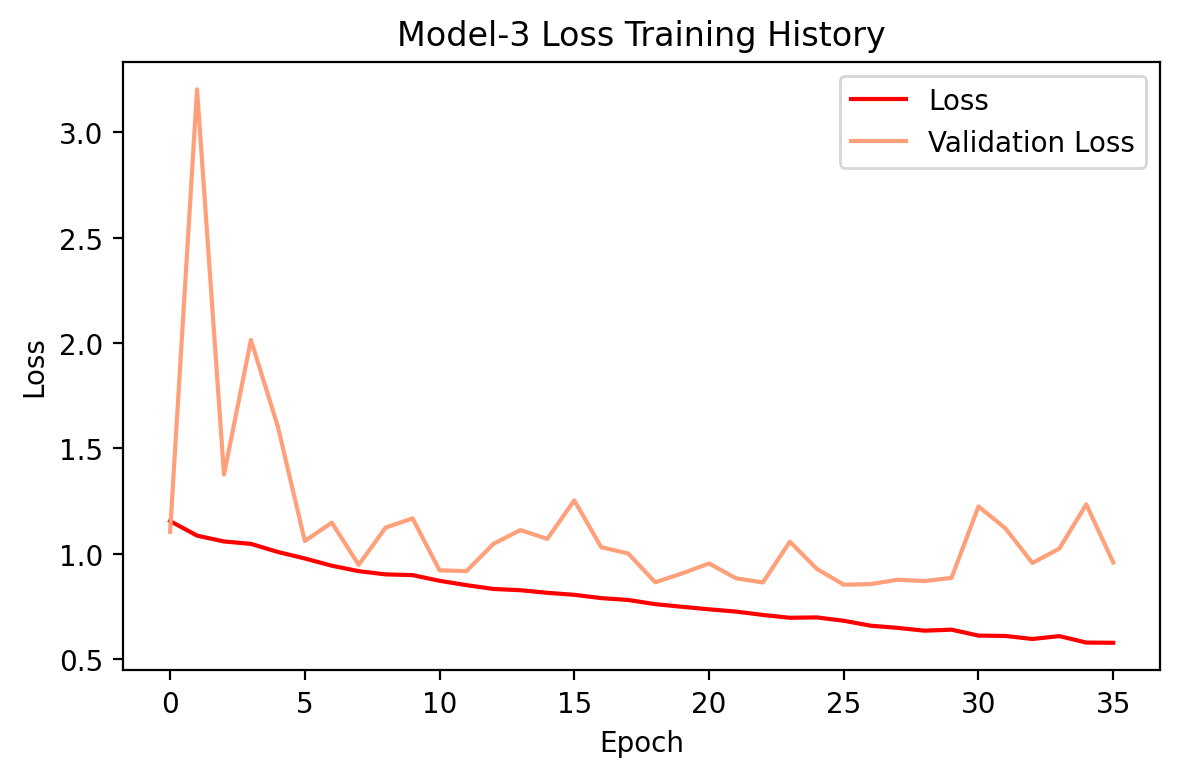

In [17]:
## Visualize training results
# Plot training history
plot_training(model_3, history_3)

  2/734 [..............................] - ETA: 42s 

2022-10-06 14:25:57.241090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 8s 10ms/step
Train:
              precision    recall  f1-score   support

      Spiral       0.71      0.86      0.78     10017
  Elliptical       0.57      0.65      0.61      5705
      Merger       0.84      0.52      0.64      7765

    accuracy                           0.70     23487
   macro avg       0.71      0.68      0.68     23487
weighted avg       0.72      0.70      0.69     23487


734/734 [==============================] - 9s 10ms/step


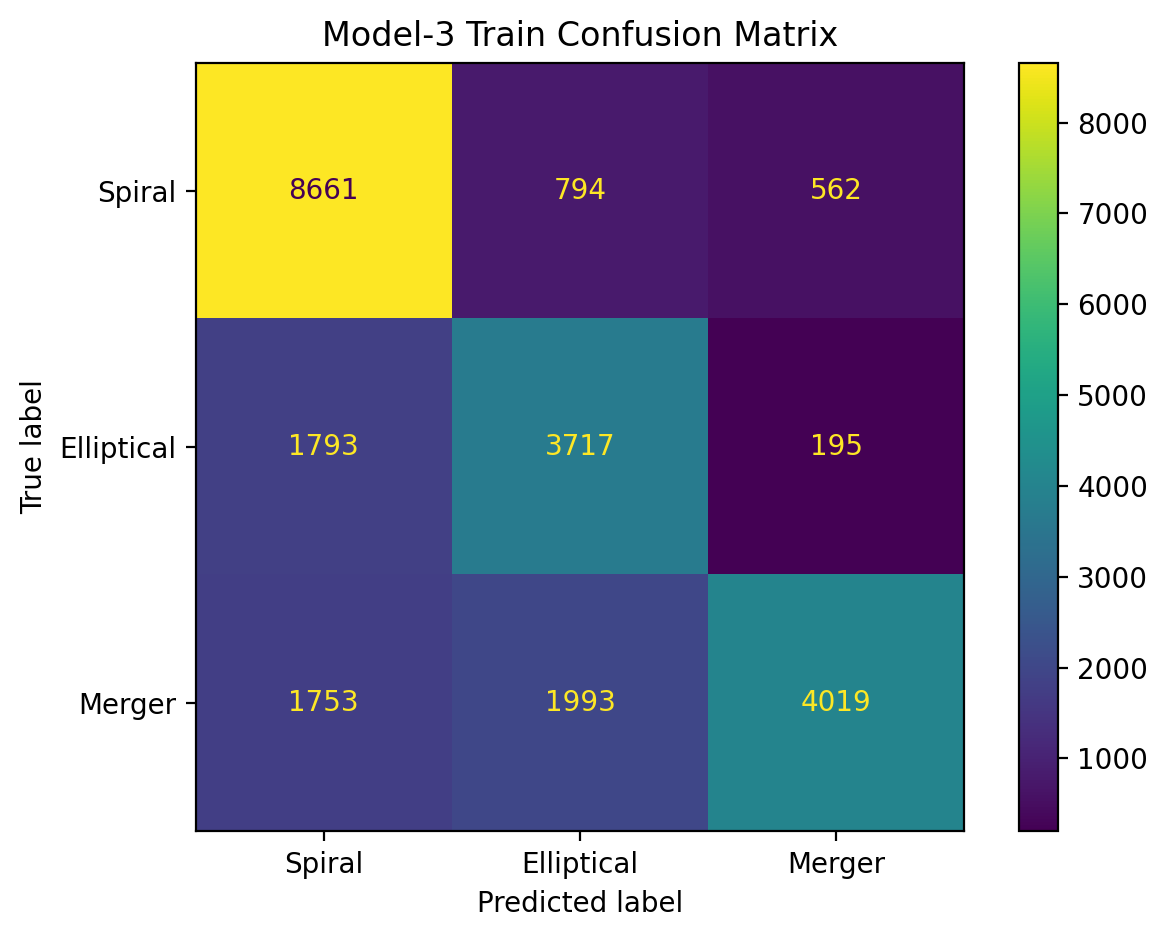

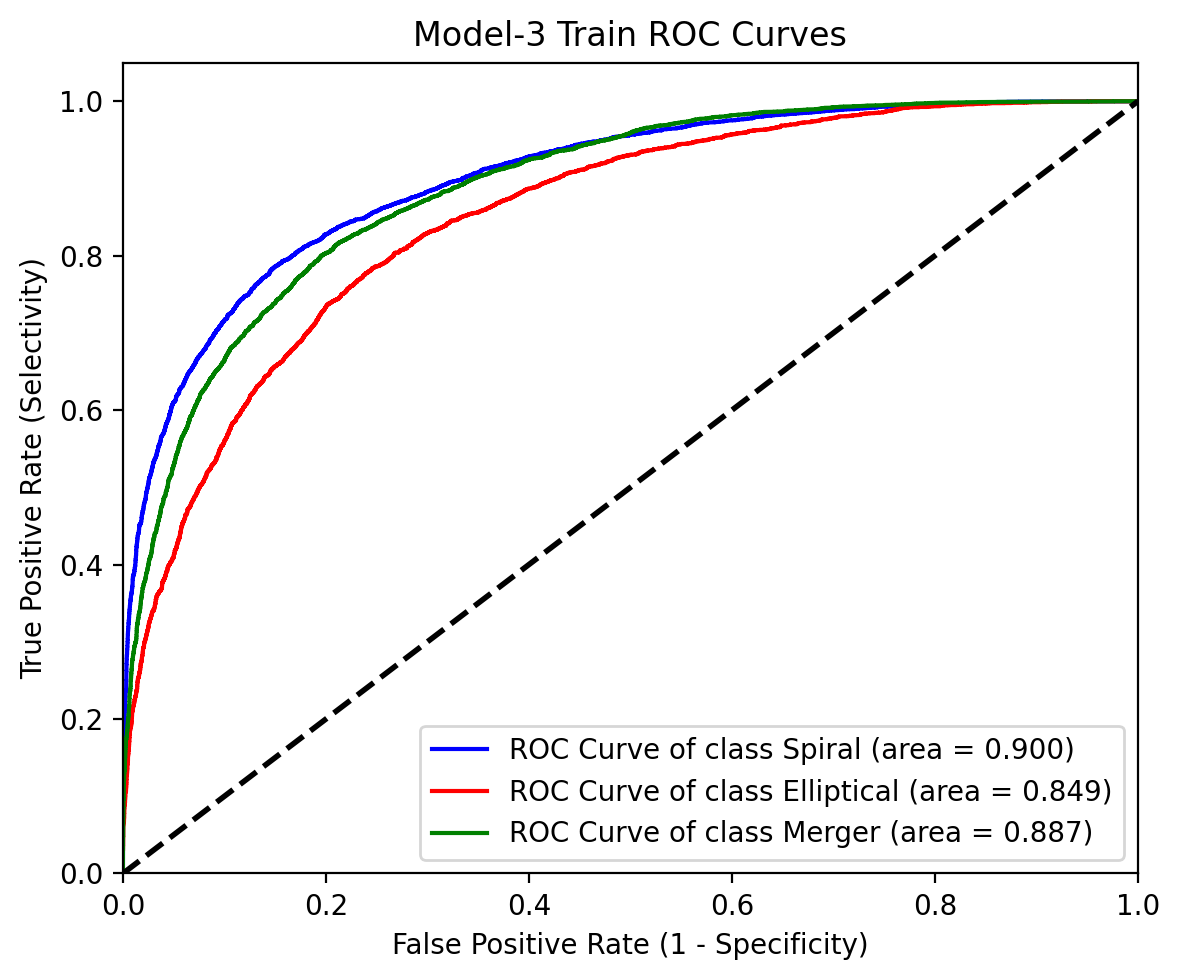

In [18]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_3.predict(X_train_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_train, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_3, 
              np.argmax(Y_train, axis=1), 
              np.argmax(model_3.predict(X_train_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_3.name} Train Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_3.name}_train_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_3.name} Train ROC Curves')
plt.savefig(fname=f'{model_3.name}_train_ROC', format='png')
plt.show()

210/210 [==============================] - 2s 12ms/step
Test:
              precision    recall  f1-score   support

      Spiral       0.66      0.82      0.73      2863
  Elliptical       0.48      0.55      0.52      1631
      Merger       0.70      0.40      0.51      2221

    accuracy                           0.62      6715
   macro avg       0.62      0.59      0.59      6715
weighted avg       0.63      0.62      0.61      6715


210/210 [==============================] - 2s 11ms/step


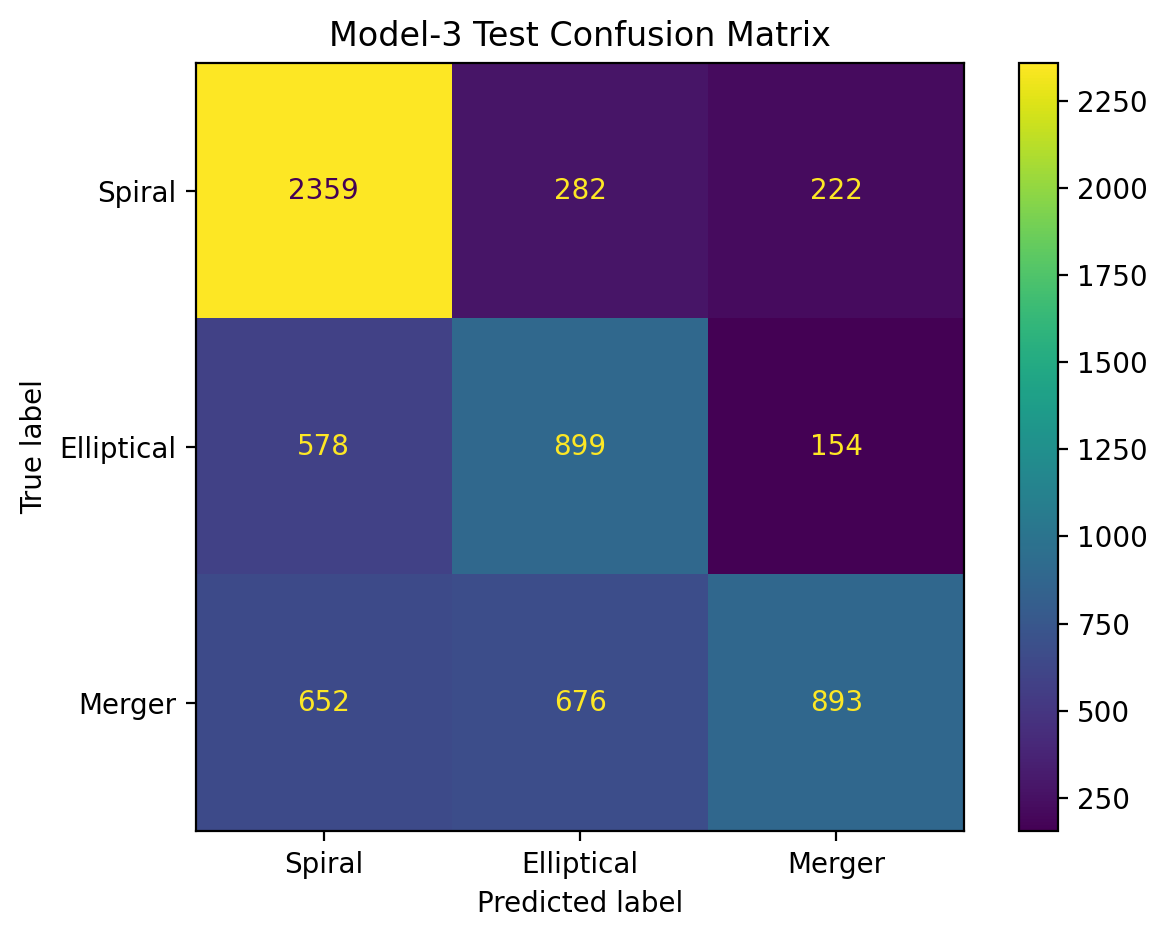

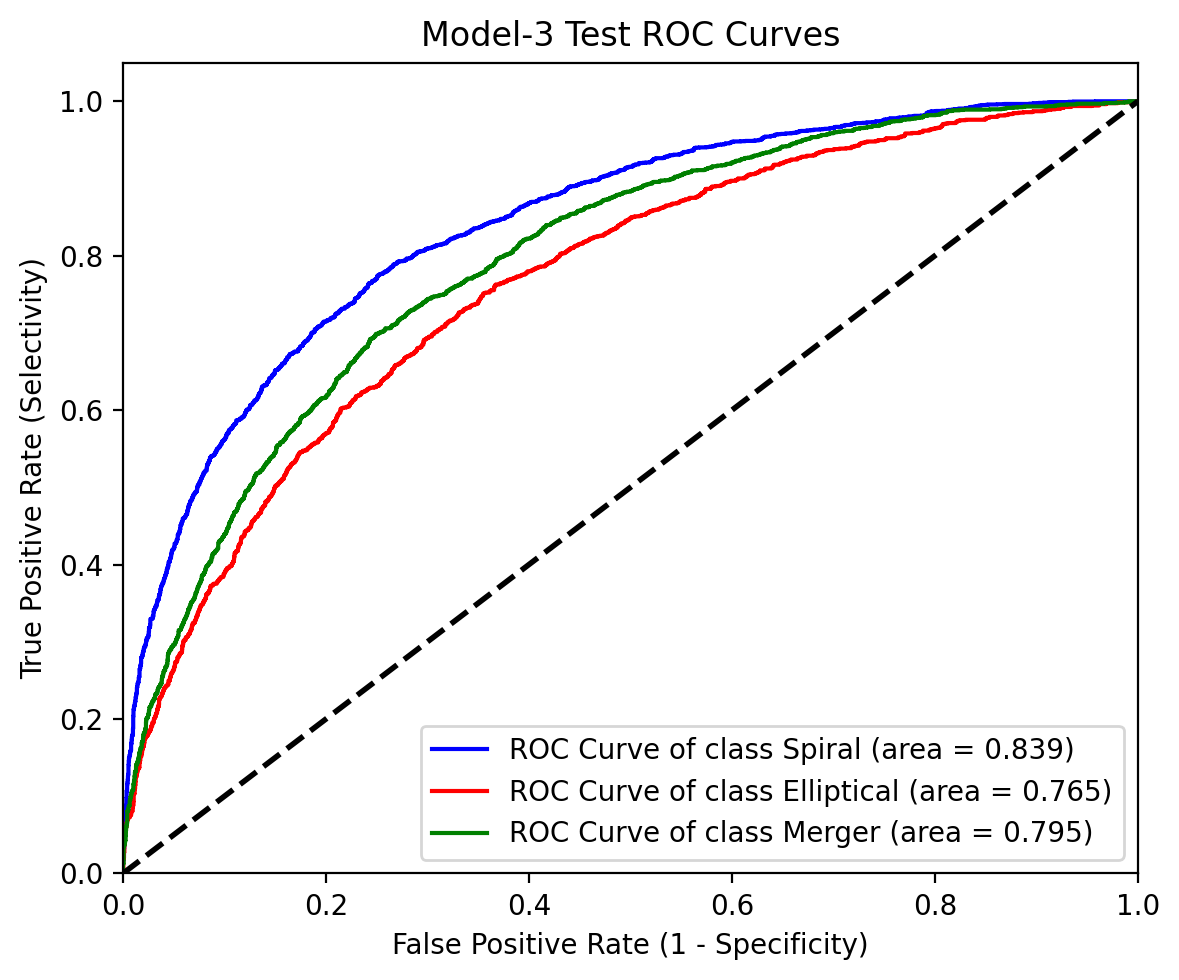

In [19]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_3.predict(X_test_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_3, 
              np.argmax(Y_test, axis=1), 
              np.argmax(model_3.predict(X_test_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_3.name} Test Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_3.name}_test_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_3.name} Test ROC Curves')
plt.savefig(fname=f'{model_3.name}_test_ROC', format='png')
plt.show()

105/105 [==============================] - 1s 11ms/step
Validation:
              precision    recall  f1-score   support

      Spiral       0.67      0.81      0.73      1432
  Elliptical       0.51      0.58      0.54       815
      Merger       0.71      0.44      0.55      1108

    accuracy                           0.63      3355
   macro avg       0.63      0.61      0.61      3355
weighted avg       0.64      0.63      0.62      3355


105/105 [==============================] - 1s 10ms/step


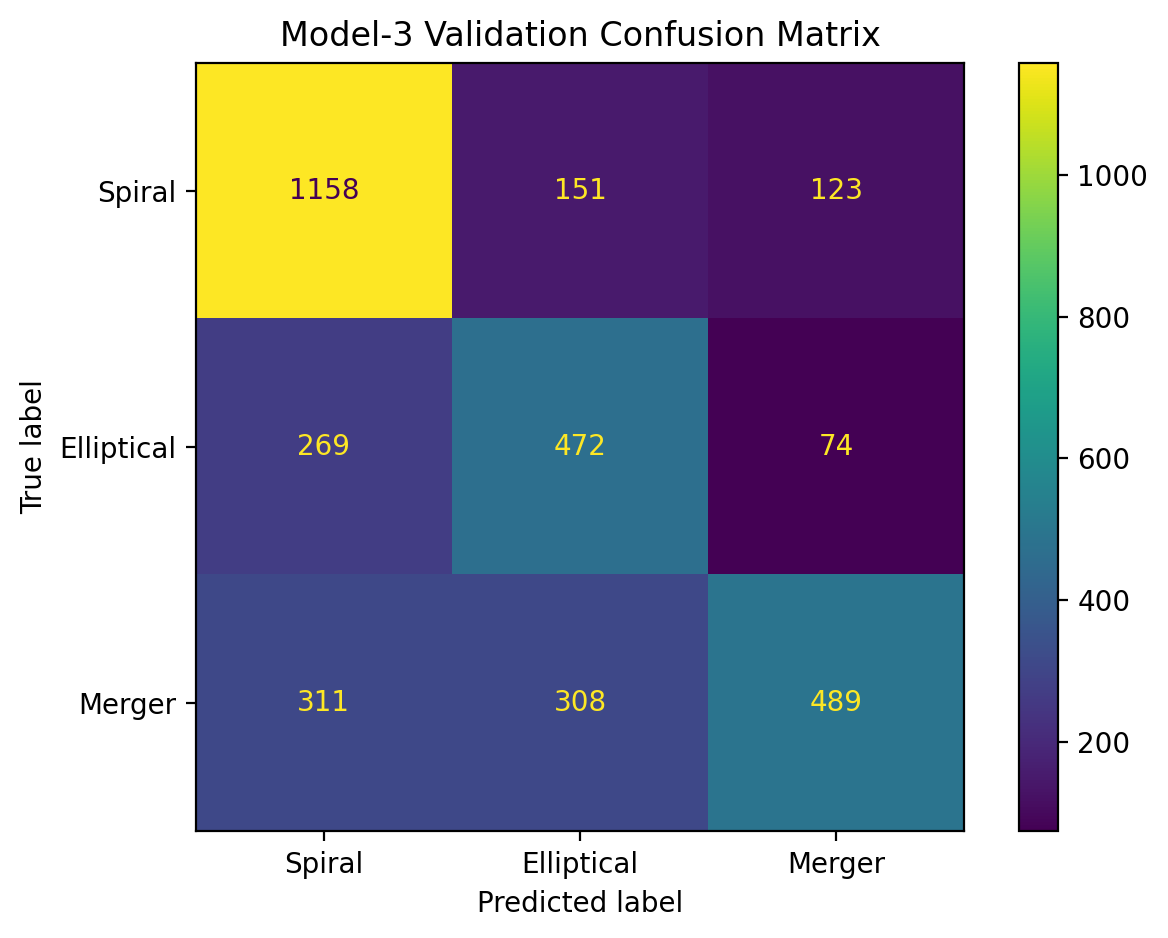

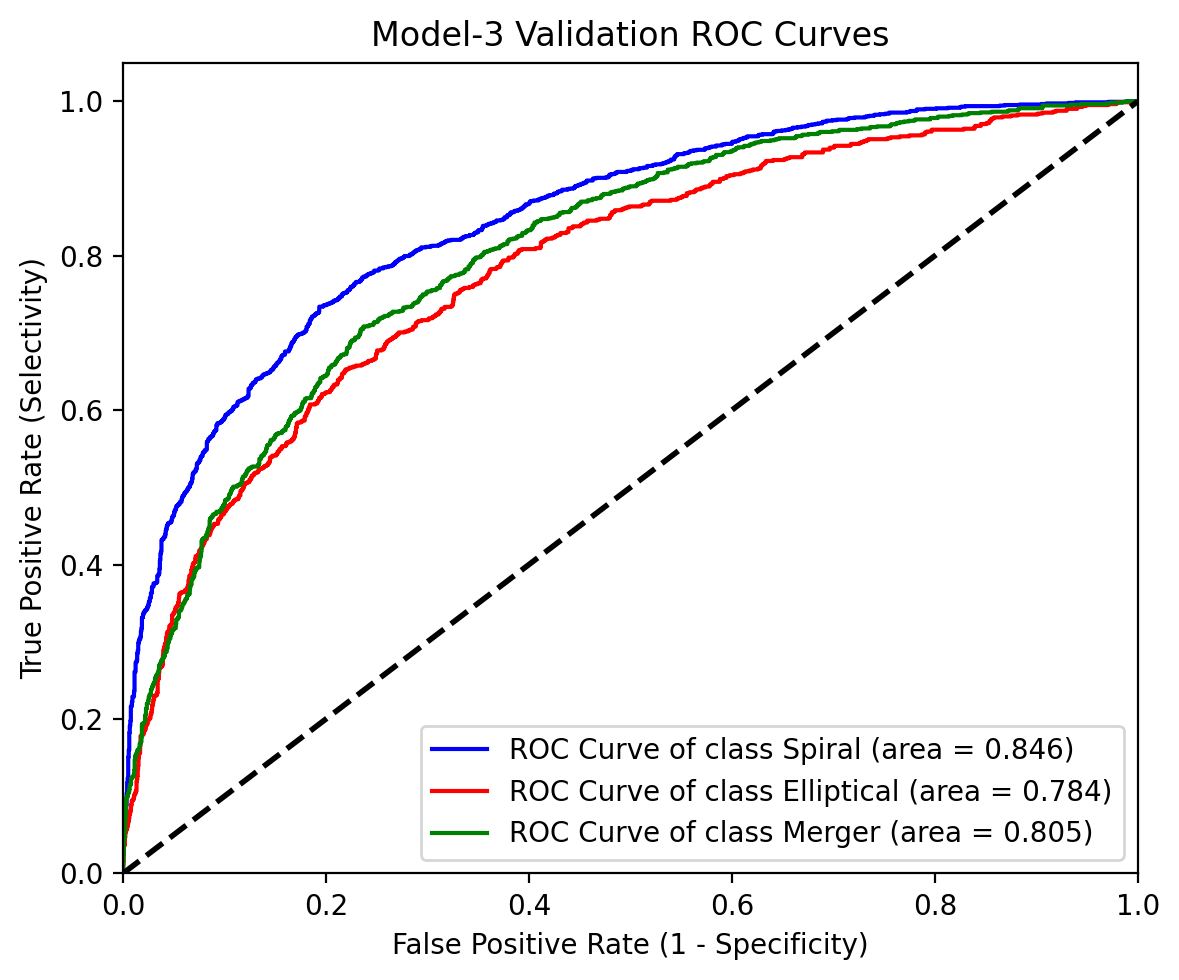

In [20]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_3.predict(X_valid_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_valid, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Validation:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_3, 
              np.argmax(Y_valid, axis=1), 
              np.argmax(model_3.predict(X_valid_1), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_3.name} Validation Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_3.name}_validation_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_3.name} Validation ROC Curves')
plt.savefig(fname=f'{model_3.name}_validation_ROC', format='png')
plt.show()

In [21]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_3.predict(X_test_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Year 10 Test:\n" + classification_metrics + '\n')

210/210 [==============================] - 2s 9ms/step
Year 10 Test:
              precision    recall  f1-score   support

      Spiral       0.45      0.99      0.61      2863
  Elliptical       0.42      0.07      0.12      1631
      Merger       0.91      0.02      0.04      2221

    accuracy                           0.45      6715
   macro avg       0.59      0.36      0.26      6715
weighted avg       0.59      0.45      0.30      6715




# Visualizing Feature/Activation Maps

In [9]:
## Load Model 1
loaded_model = load_model('Model-1')
# Extracts the outputs of all layers except the input layer
layer_outputs = [layer.output for layer in loaded_model.layers[1:]]

# Creates model that will return these outputs, given the model input
activation_model = models.Model(inputs=loaded_model.input, outputs=layer_outputs) 

# returns the values of the layer activations in model
# Returns a list of Numpy arrays: one array per layer activation
activations = activation_model.predict(X_test_10) 

2022-10-05 21:31:20.143637: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-05 21:31:20.589145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 6s 22ms/step


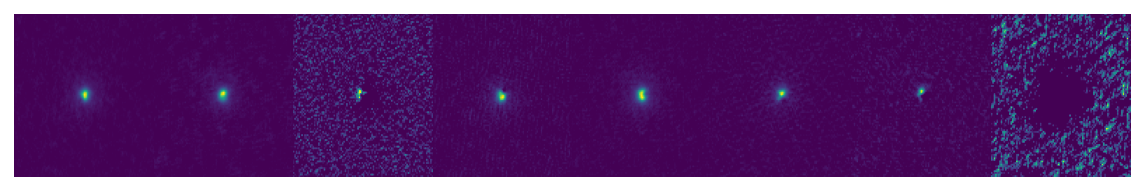

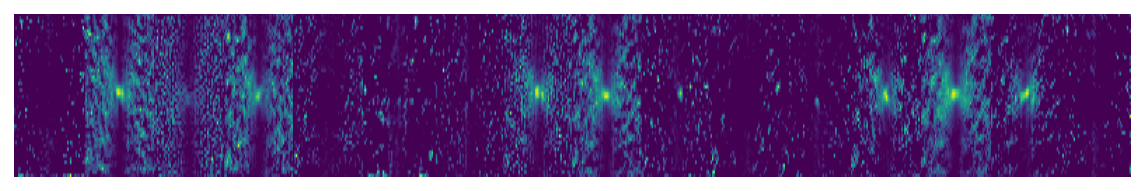

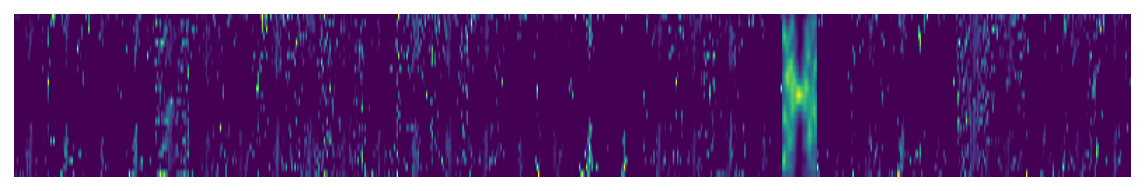

In [39]:
# activation maps for all filters in each convolutional layer
fig1=plt.figure(figsize=(11,1.5))  
for i in range(8):
    plt.subplot(1, 8, i + 1)
    layer_activation = activations[0]
    plt.imshow(layer_activation[1649, i, :, :], cmap='viridis', aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)

fig2=plt.figure(figsize=(11,3))  
for i in range(16):
    plt.subplot(2, 16, i + 1)
    layer_activation = activations[4]
    plt.imshow(layer_activation[1649, i, :, :], cmap='viridis', aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)
    
fig3=plt.figure(figsize=(15,6))  
for i in range(32):
    plt.subplot(4, 32, i + 1)
    layer_activation = activations[8]
    plt.imshow(layer_activation[1649, i, :, :], cmap='viridis', aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)
    

In [42]:
# seraching for examples
prob = model1.predict(X_test_10)
pred =  (prob > 0.5).astype('int32') 

for i in range(len(Y_test)):
    if (Y_test[i] == 1 and pred[i,0] == 1): # and other y_test vs pered combinations TP=(1,1), FP=(0,1), TN=(0,0), FN=(1,0)
        print (i)
        print(Y_test[i],pred[i])

210/210 [==============================] - 2s 9ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Fine Tuning - Transfer Learning

Trying to transfer ability to extract features over to new dataset. Initialize network w/ the weights from saved model, freeze all Conv2D & Max-pooling layers so weights not modified.

-We expect this performance to likely be worse since images are noisier.

-All images in both source and target domain are labeled: Inductive transfer learning 

-Using saved model as a fixed feature extractor for noisy data.


In [88]:
# remove fully connected layers of model and add to classifier 
# to fine-tune; make last layer the output

#(channels, rows, cols)
input_shape = (3, 100, 100)

# Constraints for layer 1
inputs = Input(shape=input_shape)
c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(inputs)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b0)
e0 = Dropout(0.5)(d0)

# Constraints for layer 2
c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b1)
e1 = Dropout(0.5)(d1)

# Constraints for layer 3
c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b2)
outputs = Dropout(0.5)(d2)

base_model = Model(inputs=inputs, outputs=outputs)

base_model.trainable = False
    
base_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv2d (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization_12 (Bat  (None, 8, 100, 100)      400       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 50, 50)        0         
 )                                                               
                                                                 
 dropout_12 (Dropout)        (None, 8, 50, 50)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 50, 50)        1168

In [93]:
input_shape = (3, 100, 100)
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
#flatten (or unroll) the 3D output to 1D
f = Flatten()(x)
z0 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001))(z0)
outputs = Dense(NUM_CLASSES, activation='softmax')(z1)

TL_model = Model(inputs=inputs, outputs=outputs)

In [94]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
      ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
      BackupAndRestore(backup_dir='backups'),
# Save best weights in order to maximize validation accuracy, only saves when the model is considered the "best"
      ModelCheckpoint(filepath='best_weights.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)]

In [95]:
# Compile Model
optimizer = 'adam'
metrics = ['accuracy']
# Multi-Class Cross-Entropy Loss
loss = 'categorical_crossentropy' 

TL_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

TL_model.summary() 

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 model_3 (Functional)        (None, 32, 12, 12)        7116      
                                                                 
 flatten_9 (Flatten)         (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                294976    
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
Total params: 304,271
Trainable params: 297,155
Non-trainab

In [96]:
# Train transfer learning model
batch_size = 128
NUM_EPOCH = 100

historyTL = TL_model.fit(X_train_1, Y_train,
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,
                    validation_data=(X_valid_1, Y_valid),
                    shuffle=True,
                    verbose=1,
                    callbacks=es
            )

Epoch 1/100


2022-06-03 22:44:56.532738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 181.4023 - accuracy: 0.3523

2022-06-03 22:45:03.470123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - 8s 41ms/step - loss: 181.4023 - accuracy: 0.3523 - val_loss: 38.5071 - val_accuracy: 0.3154 - lr: 0.0010
Epoch 2/100
183/184 [============================>.] - ETA: 0s - loss: 84.4625 - accuracy: 0.3548WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 7s 36ms/step - loss: 84.3864 - accuracy: 0.3547 - val_loss: 31.2569 - val_accuracy: 0.3168 - lr: 0.0010
Epoch 3/100
183/184 [============================>.] - ETA: 0s - loss: 60.4086 - accuracy: 0.3603WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 34ms/step - loss: 60.4191 - accuracy: 0.3602 - val_loss: 35.5226 - val_accuracy: 0.3967 - lr: 0.0010
Epoch 4/100
183/184 [============================>.] - ETA: 0s - loss: 37.6500 - accuracy: 0.3707WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 33ms/step - loss: 37.6182 - accuracy: 0.3706 - val_loss: 25.3239 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 5/100
184/184 [==============================] - ETA: 0s - loss: 23.0700 - accuracy: 0.3707WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 35ms/step - loss: 23.0700 - accuracy: 0.3707 - val_loss: 25.3026 - val_accuracy: 0.3404 - lr: 0.0010
Epoch 6/100
183/184 [============================>.] - ETA: 0s - loss: 17.5379 - accuracy: 0.3782WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 32ms/step - loss: 17.5342 - accuracy: 0.3780 - val_loss: 22.6165 - val_accuracy: 0.3389 - lr: 0.0010
Epoch 7/100
183/184 [============================>.] - ETA: 0s - loss: 19.3632 - accuracy: 0.3753WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 32ms/step - loss: 19.3362 - accuracy: 0.3753 - val_loss: 20.0432 - val_accuracy: 0.3586 - lr: 0.0010
Epoch 8/100
183/184 [============================>.] - ETA: 0s - loss: 10.6356 - accuracy: 0.3827WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 32ms/step - loss: 10.6252 - accuracy: 0.3829 - val_loss: 9.8152 - val_accuracy: 0.3508 - lr: 0.0010
Epoch 9/100
183/184 [============================>.] - ETA: 0s - loss: 9.0106 - accuracy: 0.3842WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 33ms/step - loss: 9.0056 - accuracy: 0.3843 - val_loss: 9.1560 - val_accuracy: 0.3070 - lr: 0.0010
Epoch 10/100
183/184 [============================>.] - ETA: 0s - loss: 6.6832 - accuracy: 0.3886WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 33ms/step - loss: 6.6820 - accuracy: 0.3884 - val_loss: 12.1274 - val_accuracy: 0.2745 - lr: 0.0010
Epoch 11/100
182/184 [============================>.] - ETA: 0s - loss: 4.8750 - accuracy: 0.3914WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 32ms/step - loss: 4.8544 - accuracy: 0.3912 - val_loss: 2.6634 - val_accuracy: 0.3243 - lr: 0.0010
Epoch 12/100
182/184 [============================>.] - ETA: 0s - loss: 2.0181 - accuracy: 0.3766WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 32ms/step - loss: 2.0164 - accuracy: 0.3763 - val_loss: 1.8988 - val_accuracy: 0.3666 - lr: 0.0010
Epoch 13/100
183/184 [============================>.] - ETA: 0s - loss: 1.6282 - accuracy: 0.3753WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 34ms/step - loss: 1.6282 - accuracy: 0.3754 - val_loss: 1.6049 - val_accuracy: 0.3058 - lr: 0.0010
Epoch 14/100
183/184 [============================>.] - ETA: 0s - loss: 1.5182 - accuracy: 0.3751WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 7s 39ms/step - loss: 1.5182 - accuracy: 0.3748 - val_loss: 1.4684 - val_accuracy: 0.3487 - lr: 0.0010
Epoch 15/100
183/184 [============================>.] - ETA: 0s - loss: 1.2804 - accuracy: 0.3833WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 7s 37ms/step - loss: 1.2800 - accuracy: 0.3837 - val_loss: 1.2537 - val_accuracy: 0.4253 - lr: 0.0010
Epoch 16/100
184/184 [==============================] - ETA: 0s - loss: 1.1733 - accuracy: 0.4025WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 7s 38ms/step - loss: 1.1733 - accuracy: 0.4025 - val_loss: 1.1304 - val_accuracy: 0.4030 - lr: 0.0010
Epoch 17/100
183/184 [============================>.] - ETA: 0s - loss: 1.1574 - accuracy: 0.4065WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 7s 36ms/step - loss: 1.1571 - accuracy: 0.4068 - val_loss: 1.1189 - val_accuracy: 0.4012 - lr: 0.0010
Epoch 18/100
183/184 [============================>.] - ETA: 0s - loss: 1.1622 - accuracy: 0.4065WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 7s 39ms/step - loss: 1.1621 - accuracy: 0.4062 - val_loss: 1.1692 - val_accuracy: 0.3523 - lr: 0.0010
Epoch 19/100
183/184 [============================>.] - ETA: 0s - loss: 1.1337 - accuracy: 0.4092WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 35ms/step - loss: 1.1340 - accuracy: 0.4091 - val_loss: 1.2061 - val_accuracy: 0.4235 - lr: 0.0010
Epoch 20/100
184/184 [==============================] - ETA: 0s - loss: 1.1829 - accuracy: 0.4007WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 35ms/step - loss: 1.1829 - accuracy: 0.4007 - val_loss: 1.1248 - val_accuracy: 0.4224 - lr: 0.0010
Epoch 21/100
183/184 [============================>.] - ETA: 0s - loss: 1.1406 - accuracy: 0.4134WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 34ms/step - loss: 1.1407 - accuracy: 0.4133 - val_loss: 1.1233 - val_accuracy: 0.3607 - lr: 0.0010
Epoch 22/100
183/184 [============================>.] - ETA: 0s - loss: 1.1669 - accuracy: 0.3997WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 34ms/step - loss: 1.1674 - accuracy: 0.3993 - val_loss: 1.2902 - val_accuracy: 0.3684 - lr: 0.0010
Epoch 22: early stopping


In [98]:
# Evaluate the model on noisy year 10 test data
score = TL_model.evaluate(X_test_10, Y_test, verbose=True)
print("%s: %.2f%%" % (TL_model.metrics_names[1], score[1]*100))


210/210 [==============================] - 3s 14ms/step - loss: 3.6009 - accuracy: 0.3574
accuracy: 35.74%


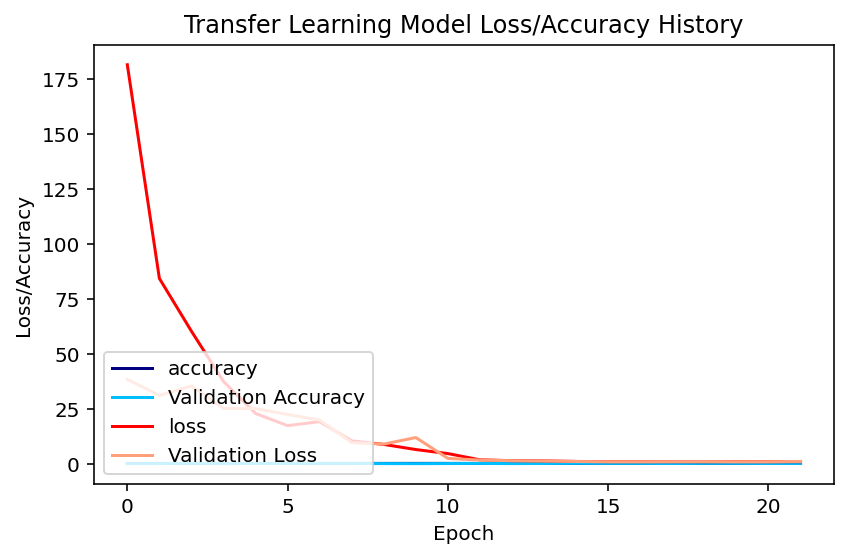

In [99]:
# Visualize training results
# Accuracy
acc = historyTL.history['accuracy']
val_acc = historyTL.history['val_accuracy']

# Loss
loss = historyTL.history['loss']
val_loss = historyTL.history['val_loss']

epochs = list(range(len(loss)))

#plot
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="Validation Accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="Validation Loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]

axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Transfer Learning Model Loss/Accuracy History")
plt.tight_layout()
axis1.legend(loc='lower left')

In [100]:
TL_model.save("TL_model.h5")

### Use ResNet for Transfer Learning?

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input


# Probabilistic CNN

Define prior and the posterior distributions of weights

Output a distribution instead of a deterministic tensor

In [105]:
# negative log-likelihood loss function
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [119]:
# define probabalistic model architecture

#(channels, rows, cols)
input_shape = (3, 100, 100)

# Constraints for layer 1
inputs = Input(shape=input_shape)
c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(inputs)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b0)
e0 = Dropout(0.5)(d0)

# Constraints for layer 2
c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b1)
e1 = Dropout(0.5)(d1)

# Constraints for layer 3
c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b2)
y = Dropout(0.5)(d2)

# flatten (or unroll) the 3D output to 1D
x = Flatten()(y)
# hidden layers
x = Dense(tfp.layers.OneHotCategorical.params_size(3))(x)
outputs = tfp.layers.OneHotCategorical(3, convert_to_tensor_fn=tfp.distributions.Distribution.mode)(x)

probabilistic_model = Model(inputs=inputs, outputs=outputs)

In [120]:
# Compile model
probabilistic_model.compile( 
    optimizer='adam',
    loss=nll,
    metrics=['accuracy']
    )

probabilistic_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 3, 100, 100)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 100, 100)       608       
                                                                 
 batch_normalization_18 (Bat  (None, 8, 100, 100)      400       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 50, 50)        0         
 2D)                                                             
                                                                 
 dropout_18 (Dropout)        (None, 8, 50, 50)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 50, 50)        1168

In [121]:
# Train the probabalistic model
NUM_EPOCH = 100
batch_size = 128

In [143]:
# validation loss and accuracy not available
es = [EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5),
      ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5),
      BackupAndRestore(backup_dir='backups'),
# Save best weights in order to maximize validation accuracy, only saves when the model is considered the "best"
      ModelCheckpoint(filepath='best_weights.h5', monitor='accuracy', mode='max', verbose=1, save_best_only=True)]

In [144]:
history_prob = probabilistic_model.fit(X_train_1, Y_train,
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,              
                    shuffle=True,
                    verbose=1,
                    callbacks=es
            )

Epoch 7/100
184/184 [==============================] - ETA: 0s - loss: 1.0975 - accuracy: 0.4162
Epoch 7: accuracy improved from -inf to 0.41619, saving model to best_weights.h5
184/184 [==============================] - 64s 348ms/step - loss: 1.0975 - accuracy: 0.4162 - lr: 0.0010
Epoch 8/100
184/184 [==============================] - ETA: 0s - loss: 1.1004 - accuracy: 0.4161
Epoch 8: accuracy did not improve from 0.41619
184/184 [==============================] - 64s 349ms/step - loss: 1.1004 - accuracy: 0.4161 - lr: 0.0010
Epoch 9/100
184/184 [==============================] - ETA: 0s - loss: 1.1025 - accuracy: 0.4140
Epoch 9: accuracy did not improve from 0.41619
184/184 [==============================] - 64s 348ms/step - loss: 1.1025 - accuracy: 0.4140 - lr: 0.0010
Epoch 10/100
184/184 [==============================] - ETA: 0s - loss: 1.1048 - accuracy: 0.4065
Epoch 10: accuracy did not improve from 0.41619
184/184 [==============================] - 64s 347ms/step - loss: 1.1048 

In [145]:
# Evaluate the model on test data
score = probabilistic_model.evaluate(X_test_1, Y_test, verbose=True)
print("%s: %.2f%%" % (probabilistic_model.metrics_names[1], score[1]*100))

# Evaluate the model on test smaller subset
score = probabilistic_model.evaluate(X_test_1_sub, Y_test_sub, verbose=True)
print("%s: %.2f%%" % (probabilistic_model.metrics_names[1], score[1]*100))


  1/210 [..............................] - ETA: 1:20 - loss: 1.1167 - accuracy: 0.3125

2022-06-04 00:46:02.942345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 4s 16ms/step - loss: 1.0941 - accuracy: 0.4208
accuracy: 42.08%
5/5 [==============================] - 0s 28ms/step - loss: 1.1312 - accuracy: 0.3600
accuracy: 36.00%


In [146]:
probabilistic_model.save('probabilistic_model_M1.h5')

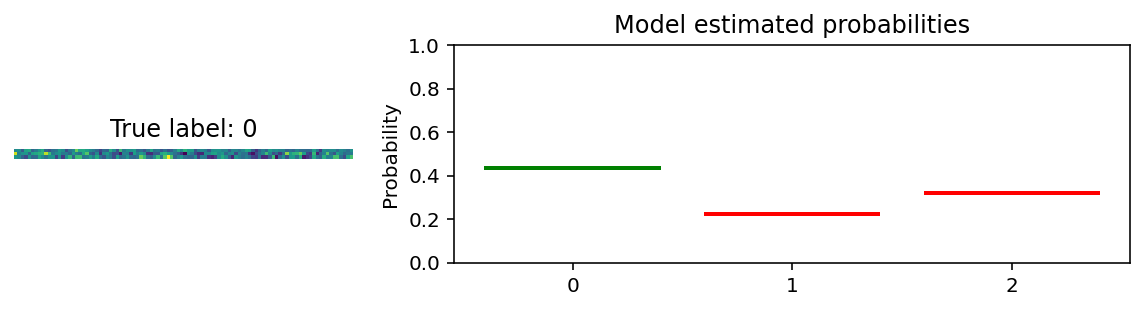

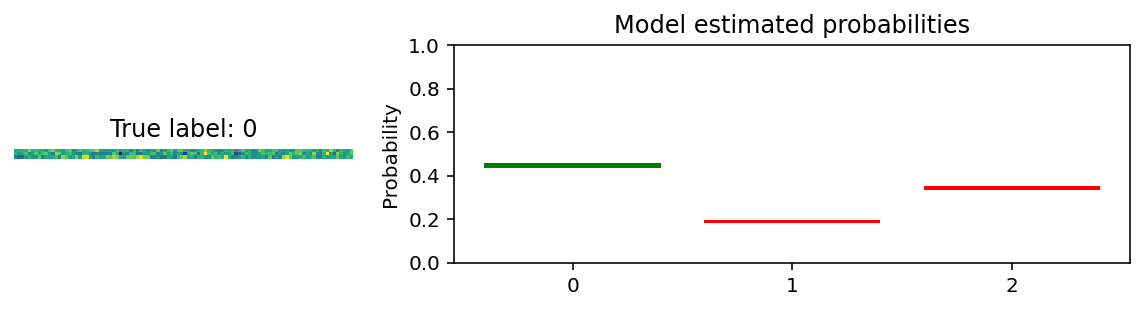

In [151]:
# look at probabilities of each class
# from https://goodboychan.github.io/python/coursera/tensorflow_probability/icl/2021/08/26/01-Bayesian-Convolutional-Neural-Network.html#Analyse-the-model-predictions
for i in [0,1577]:
    image = X_test_1[i]
    true_label = Y_test[i, 0]
    predicted_probabilities = np.empty(shape=(1, 3))
    
    for i in range(1):
        predicted_probabilities[i] = probabilistic_model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = probabilistic_model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image[..., 0])
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    # Show a 95% prediction interval of model predicted probabilities
    # make plots of probabilities that the model estimates
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(3)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(3)])    
    bar = ax2.bar(np.arange(3), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(3), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(3))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()

In [172]:
# Visualize training results
# Accuracy
acc = history_prob.history['accuracy']

# Loss
loss = history_prob.history['loss']

epochs = list(range(len(loss)))

#plot
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')

plots = plot1_loss + plot1_lacc
labs = [l.get_label() for l in plots]

axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("BNN Model Loss/Accuracy History")
plt.tight_layout()
axis1.legend(loc='lower left')

TypeError: 'History' object is not subscriptable

# Bayesian Neural Network

In [165]:
# define prior and posterior distributions
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [166]:
tf.random.set_seed(0)
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / X_train_1.shape[0]
kl_weight = 1 / X_train_1.shape[0]

In [169]:
# define bayesian model architecture

#(channels, rows, cols)
input_shape = (3, 100, 100)

# Constraints for layer 1
# For Reparameterization Layer
inputs = Input(shape=input_shape)
c0 = tfpl.Convolution2DReparameterization(
                filters=8, kernel_size=(5, 5),
                activation='relu', padding='same', data_format='channels_first',
                kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                kernel_divergence_fn=divergence_fn,
                bias_prior_fn=tfpl.default_multivariate_normal_fn,
                bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                bias_divergence_fn=divergence_fn
            )(inputs)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b0)
e0 = Dropout(0.5)(d0)

# Constraints for layer 2
c1 = tfpl.Convolution2DReparameterization(
                filters=16, kernel_size=(3, 3),
                activation='relu', padding='same', data_format='channels_first',
                kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                kernel_divergence_fn=divergence_fn,
                bias_prior_fn=tfpl.default_multivariate_normal_fn,
                bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                bias_divergence_fn=divergence_fn
            )(e0)

b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b1)
e1 = Dropout(0.5)(d1)

# Constraints for layer 3
c2 = tfpl.Convolution2DReparameterization(
                filters=32, kernel_size=(3, 3),
                activation='relu', padding='same', data_format='channels_first',
                kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                kernel_divergence_fn=divergence_fn,
                bias_prior_fn=tfpl.default_multivariate_normal_fn,
                bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                bias_divergence_fn=divergence_fn
            )(e1)

b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b2)
y = Dropout(0.5)(d2)

# flatten (or unroll) the 3D output to 1D
x = Flatten()(y)

# For Dense Variational Layer
x = tfp.layers.DenseVariational(
        units=3, make_posterior_fn=posterior, make_prior_fn=prior, kl_weight=kl_weight)(x)
outputs = tfp.layers.OneHotCategorical(3, convert_to_tensor_fn=tfp.distributions.Distribution.mode)(x)


In [170]:
bayesian_model = Model(inputs=inputs, outputs=outputs)

bayesian_model.compile( 
    optimizer='adam',
    loss=nll,
    metrics=['accuracy'],
    experimental_run_tf_function=False
    )

bayesian_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 3, 100, 100)]     0         
                                                                 
 conv2d_reparameterization_1  (None, 8, 100, 100)      1216      
 5 (Conv2DReparameterization                                     
 )                                                               
                                                                 
 batch_normalization_36 (Bat  (None, 8, 100, 100)      400       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 8, 50, 50)        0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 8, 50, 50)         0  

In [171]:
historyBNN = bayesian_model.fit(X_train_1, Y_train,
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,              
                    shuffle=True,
                    verbose=1,
                    callbacks=es
            )

Epoch 1/100


2022-06-04 01:01:40.137560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 312.1453 - accuracy: 0.3368
Epoch 1: accuracy did not improve from 0.45838
184/184 [==============================] - 403s 2s/step - loss: 312.1453 - accuracy: 0.3368 - lr: 0.0010
Epoch 2/100
184/184 [==============================] - ETA: 0s - loss: 124.0086 - accuracy: 0.3435
Epoch 2: accuracy did not improve from 0.45838
184/184 [==============================] - 418s 2s/step - loss: 124.0086 - accuracy: 0.3435 - lr: 0.0010
Epoch 3/100
184/184 [==============================] - ETA: 0s - loss: 74.6073 - accuracy: 0.3400
Epoch 3: accuracy did not improve from 0.45838
184/184 [==============================] - 399s 2s/step - loss: 74.6073 - accuracy: 0.3400 - lr: 0.0010
Epoch 4/100
184/184 [==============================] - ETA: 0s - loss: 53.0653 - accuracy: 0.3525
Epoch 4: accuracy did not improve from 0.45838
184/184 [==============================] - 402s 2s/step - loss: 53.0653 - accuracy: 0.3525 - lr: 0.0010
Epoch 5/100


KeyboardInterrupt: 

In [173]:
# Evaluate the BNN model on test data
score = bayesian_model.evaluate(X_test_1, Y_test, verbose=False)
print("%s: %.2f%%" % (bayesian_model.metrics_names[1], score[1]*100))

# Evaluate the BNN model on test smaller subset
score = bayesian_model.evaluate(X_test_1_sub, Y_test_sub, verbose=False)
print("%s: %.2f%%" % (bayesian_model.metrics_names[1], score[1]*100))

2022-06-04 01:39:11.929874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


accuracy: 33.54%
accuracy: 35.33%


In [ ]:
for i in [0,1577]:
    image = X_test_1[i]
    true_label = Y_test[i, 0]
    predicted_probabilities = np.empty(shape=(200, 3))
    
    for i in range(200):
        predicted_probabilities[i] = bayesian_model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = bayesian_model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    # Show a 95% prediction interval of model predicted probabilities
    # make plots of probabilities that the model estimates
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(3)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(3)])    
    bar = ax2.bar(np.arange(3), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(3), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(3))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()

In [ ]:
# Visualize training results
# Accuracy
acc = historyBNN.history['accuracy']

# Loss
loss = historyBNN.history['loss']

epochs = list(range(len(loss)))

#plot
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')

plots = plot1_loss + plot1_lacc
labs = [l.get_label() for l in plots]

axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("BNN Model Loss/Accuracy History")
plt.tight_layout()
axis1.legend(loc='lower left')

In [ ]:
bayesian_model.save('bayesian_model_M1.h5')

In [ ]:
## plot entropy distribution later

## need to re-run fit for probabilistic and bnn w/ validation data, was somehow left out